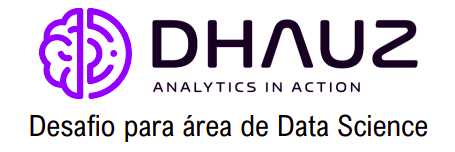


   # **1 - ENTENDIMENTO DO PROBLEMA DE NEGÓCIO A SER RESOLVIDO**

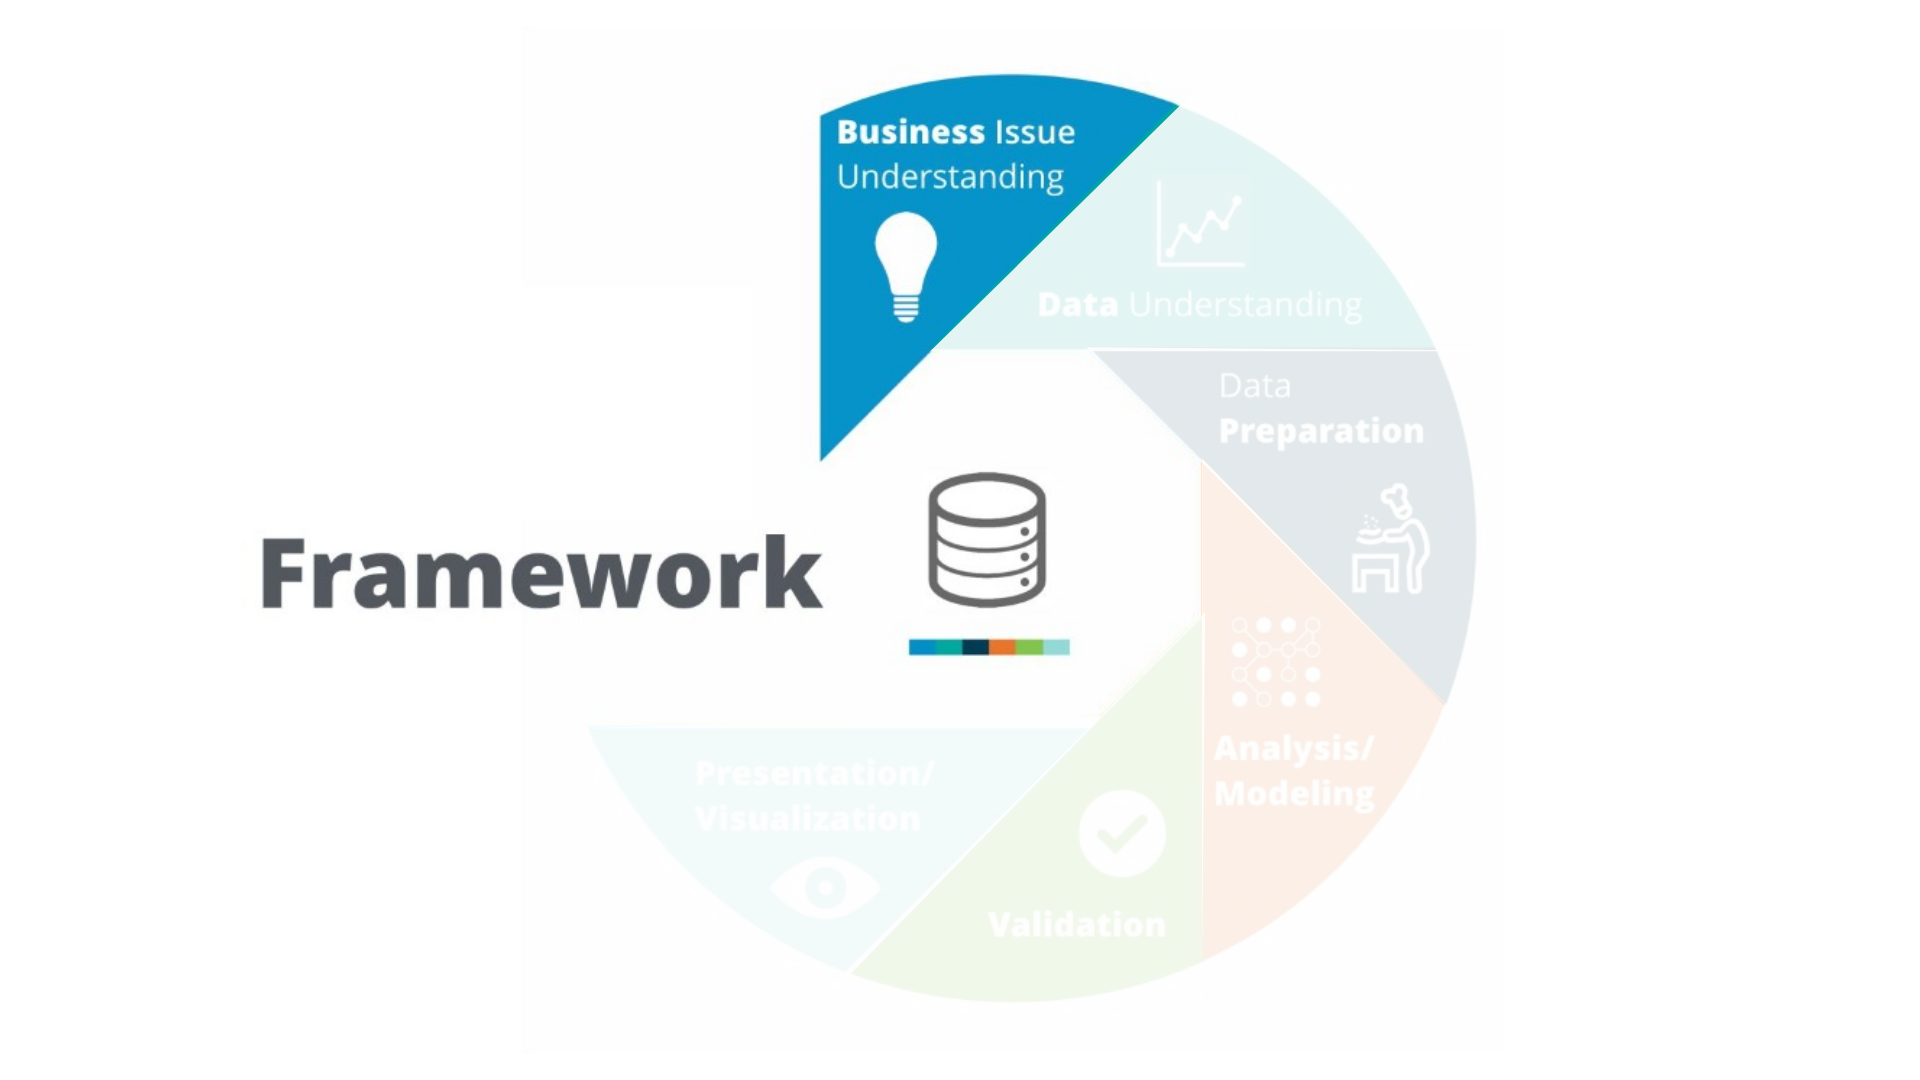

### Objetivo: 

Previsão de cancelamentos em Hotéis Você foi contratado pela DHAUZ como cientista de dados para analisar uma base de dados de clientes de uma rede de Hotéis e sua tarefa é investigar os dados em busca de insights que possam ajudar a empresa a evitar cancelamentos e também construir um modelo preditivo que possa antecipar esses cancelamentos, de modo que a empresa tenha tempo hábil para agir com ações de retenção. Informações sobre o dataset:

As informações são anonimizadas por questões de privacidade

Base de dados no link:
https://dhauz-challenges.s3.amazonaws.com/cancellation_prediction.rar


### Entregáveis: 

a) Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras duas variáveis presentes no dataset;

b) Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize métricas adequadas para argumentar a efetividade do modelo;

c) Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em 2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?alidação em 2017).
Os resultados são diferentes? Qual o mais indicado?


In [111]:
# Importaçao de pacotes e libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Funcoes
def varqual(data, col, order):    
    """ Plotar um gráfico de freq. (argumentos: dataset, feature, title, ordenamento)"""
    print(col)
    print('*' * 80, '\n')
    print(((data[col].value_counts(normalize=True)*100)).round(2))

    fig, (ax1) = plt.subplots(1,1 ,figsize=(18,5))
    ax = sns.countplot(data = data, x = col, order=order,palette='rocket')
    ax.set_title('Contagem por ' + col + ' todos os anos (2015,2016,2017)')
    
    for i in ax.patches:
        ax.annotate(i.get_height(),
                    (i.get_x() + i.get_width() / 2, i.get_height()),
                    ha='center',
                    va='baseline',
                    fontsize=12,
                    color='black',
                    xytext=(0, 1),
                    textcoords='offset points')    
    plt.show()
    
    
def varnum(data, col):
    """ Plota dois gráficos boxplot e distribuiçao (argumentos: dataset, feature, title)"""
    print('Describe ----- ' + col)
    print(data[col].describe().round(2))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))
    sns.boxplot(data[col], ax=ax1, showmeans=True, palette='rocket')
    sns.distplot(data[col], bins=20, ax=ax2, color='purple')   
    
def qual_qual(data, col, col2):
    """ Plota gráfico de barras (argumentos: dataset, feature, feature_target)"""
    analise_qual = data.groupby([col, col2]).size().unstack()
    ax = (analise_qual.T*100/analise_qual.T.sum()).T.plot(kind='bar',
    figsize=(18,5),width=0.3, color=['greenyellow','lightsalmon'],stacked=True, rot=0)
    ax.set_title('Relaçao entre ' + col + ' x ' + col2)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x ,y = p.get_xy()
        ax.annotate('{:.2f}%'.format(height), (x + width/2, y + height*0.2), ha='center') 
     
    plt.show() 
    
def info(data):
  print('PRINCIPAIS INFORMAÇÕES DO DATASET', '\n')
  print('*' * 80, '\n')
  print('Shape:', data.shape, '\n')
  print('*' * 80, '\n')
  print( 'Types', '\n')
  print(data.dtypes, '\n')
  print('*' * 80, '\n')
  print('Unique Values', '\n')
  print(data.nunique(), '\n')
  print('*' * 80, '\n')
  print('% Missing Values', '\n')
  print((data.isnull().sum() /len(data))*100, '\n')   
    
def drop_outlier(data, col):

    fator = 1.5

    q3, q1 = np.percentile(data[col],[.75, .25])

    iqr = q3 - q1

    lowpass = q1 - (iqr * fator)

    highpass = q3 + (iqr * fator)

    return [i for i in cols if i > lowpass and i < highpass]    

# **2 - ENTENDIMENTO DA BASE DE DADOS**

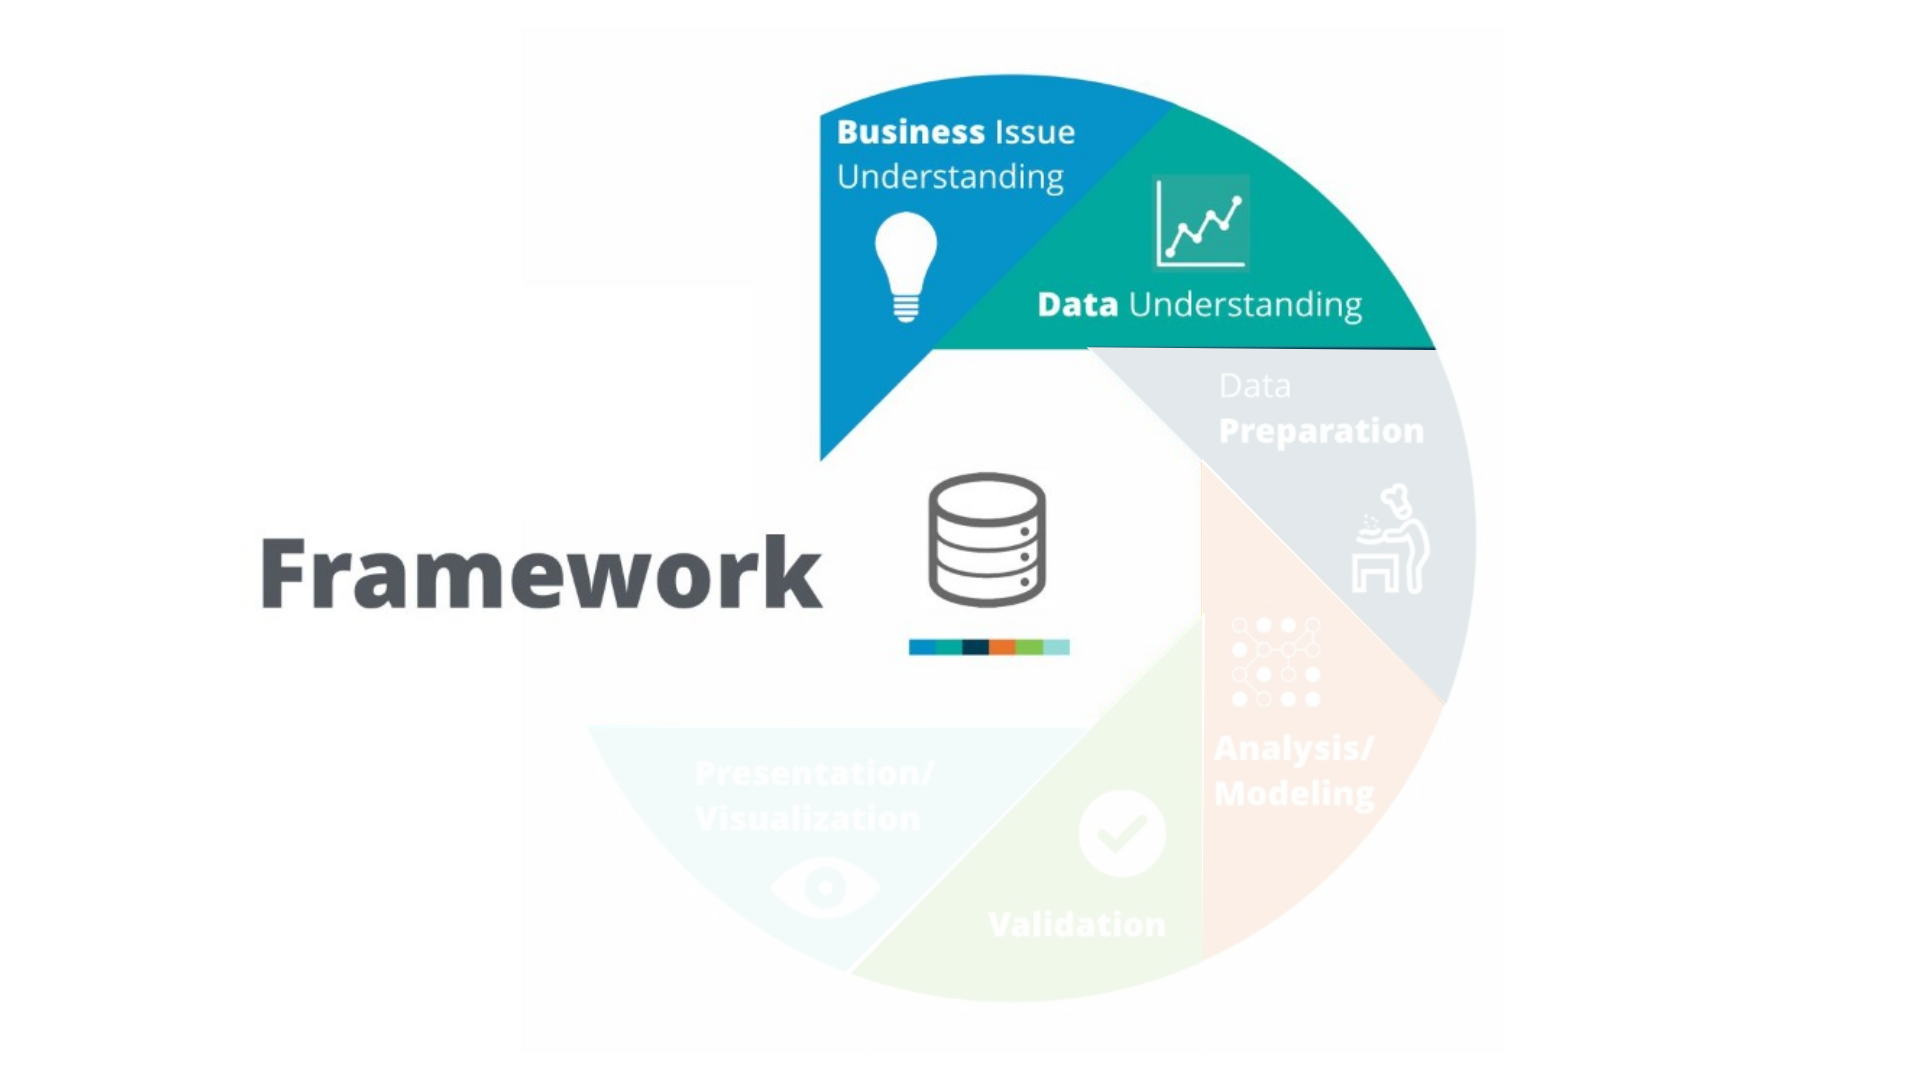

## 2.1 - ANÁLISE EXPLORATÓRIA E DESCRITIVA

In [3]:
# Carga dos dados
df = pd.read_csv('cancellation_prediction .csv', sep=',', encoding='utf8')

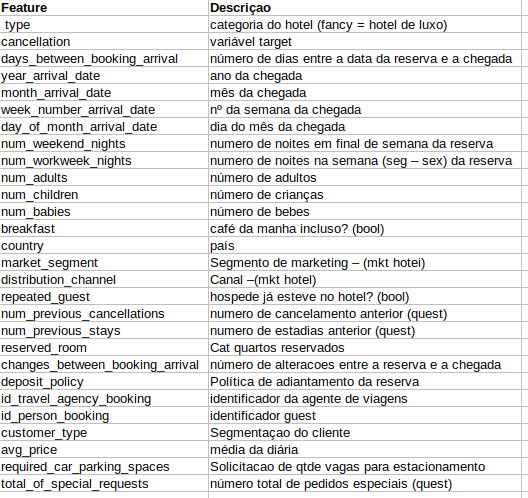

In [4]:
df.head()

type  cancellation  days_between_booking_arrival  year_arrival_date  \
0  Fancy Hotel             0                           342               2015   
1  Fancy Hotel             0                           737               2015   
2  Fancy Hotel             0                             7               2015   
3  Fancy Hotel             0                            13               2015   
4  Fancy Hotel             0                            14               2015   

  month_arrival_date  week_number_arrival_date  day_of_month_arrival_date  \
0               July                        27                          1   
1               July                        27                          1   
2               July                        27                          1   
3               July                        27                          1   
4               July                        27                          1   

   num_weekend_nights  num_workweek_nights  num_adults  ...  \
0                   0                    0           2  ...   
1                   0                    0           2  ...   
2                   0                    1           1  ...   
3                   0                    1           1  ...   
4                   0                    2           2  ...   

   num_previous_stays  reserved_room  changes_between_booking_arrival  \
0                   0              C                                3   
1                   0              C                                4   
2                   0              A                                0   
3                   0              A                                0   
4                   0              A                                0   

  deposit_policy  id_travel_agency_booking  id_person_booking  customer_type  \
0     No Deposit                       NaN                NaN              0   
1     No Deposit                       NaN                NaN              0   
2     No Deposit                       NaN                NaN              0   
3     No Deposit                     304.0                NaN              0   
4     No Deposit                     240.0                NaN              0   

   avg_price  required_car_parking_spaces total_of_special_requests  
0        0.0                            0                         0  
1        0.0                            0                         0  
2       75.0                            0                         0  
3       75.0                            0                         0  
4       98.0                            0                         1  

[5 rows x 28 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             119390 non-null  object 
 1   cancellation                     119390 non-null  int64  
 2   days_between_booking_arrival     119390 non-null  int64  
 3   year_arrival_date                119390 non-null  int64  
 4   month_arrival_date               119390 non-null  object 
 5   week_number_arrival_date         119390 non-null  int64  
 6   day_of_month_arrival_date        119390 non-null  int64  
 7   num_weekend_nights               119390 non-null  int64  
 8   num_workweek_nights              119390 non-null  int64  
 9   num_adults                       119390 non-null  int64  
 10  num_children                     119386 non-null  float64
 11  num_babies                       119390 non-null  int64  
 12  br

In [6]:
df.columns

Index(['type', 'cancellation', 'days_between_booking_arrival',
       'year_arrival_date', 'month_arrival_date', 'week_number_arrival_date',
       'day_of_month_arrival_date', 'num_weekend_nights',
       'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
       'breakfast', 'country', 'market_segment', 'distribution_channel',
       'repeated_guest', 'num_previous_cancellations', 'num_previous_stays',
       'reserved_room', 'changes_between_booking_arrival', 'deposit_policy',
       'id_travel_agency_booking', 'id_person_booking', 'customer_type',
       'avg_price', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

### 2.1.1 - ANÁLISE UNIVARIADA - VARIÁVEIS QUALITATIVAS

type
******************************************************************************** 

Hotel          66.45
Fancy Hotel    33.55
Name: type, dtype: float64


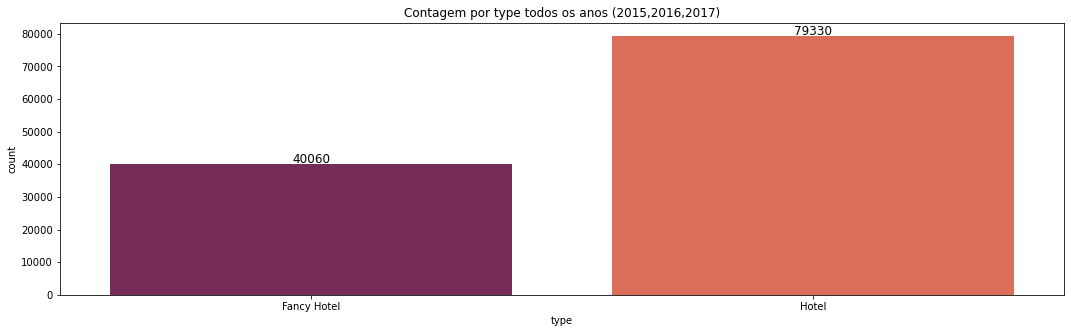

In [7]:
varqual(df, 'type', None)

cancellation
******************************************************************************** 

0    62.96
1    37.04
Name: cancellation, dtype: float64


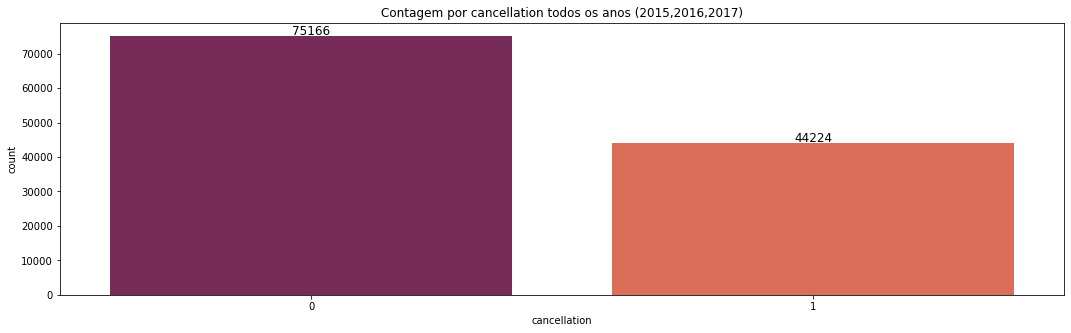

In [8]:
varqual(df, 'cancellation', None)

year_arrival_date
******************************************************************************** 

2016    47.50
2017    34.08
2015    18.42
Name: year_arrival_date, dtype: float64


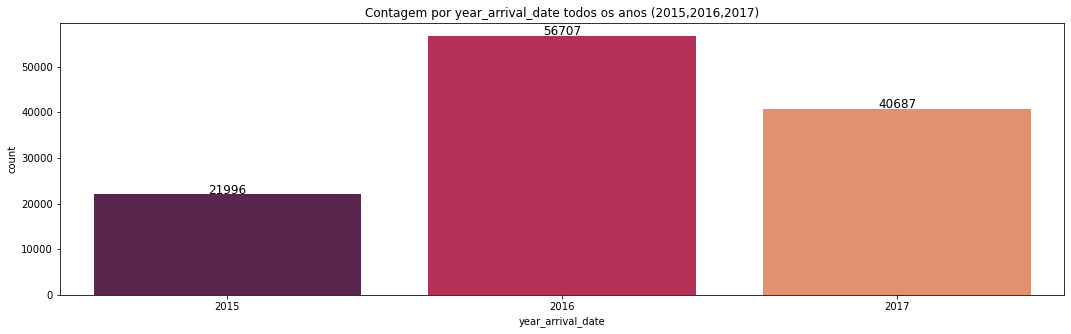

In [9]:
varqual(df, 'year_arrival_date', None)

month_arrival_date
******************************************************************************** 

August       11.62
July         10.60
May           9.88
October       9.35
April         9.29
June          9.16
September     8.80
March         8.20
February      6.76
November      5.69
December      5.68
January       4.97
Name: month_arrival_date, dtype: float64


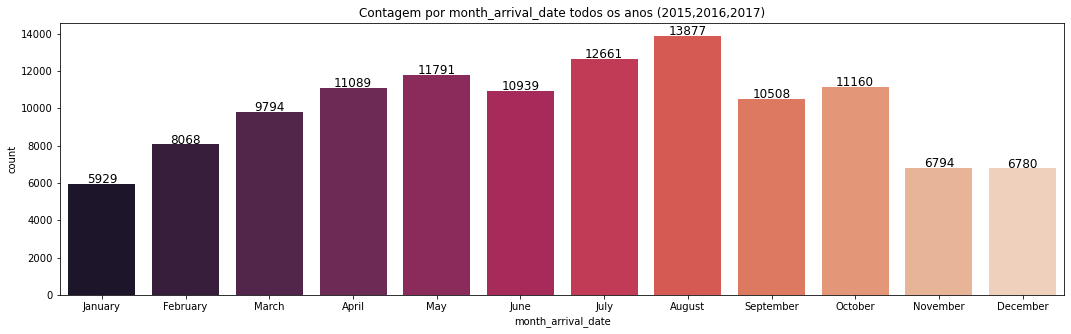

In [10]:
order = ['January', 'February', 'March', 'April','May','June','July','August','September', 'October',
        'November', 'December']
varqual(df, 'month_arrival_date', order)

week_number_arrival_date
******************************************************************************** 

33    3.00
30    2.59
32    2.55
34    2.55
18    2.45
21    2.39
28    2.39
17    2.35
20    2.33
29    2.31
42    2.31
31    2.30
41    2.26
15    2.25
27    2.23
25    2.23
38    2.23
23    2.20
35    2.17
39    2.16
22    2.13
24    2.09
13    2.02
16    2.01
19    2.01
40    2.01
26    2.00
43    1.97
44    1.90
14    1.90
37    1.87
8     1.86
36    1.82
10    1.80
9     1.77
7     1.77
12    1.74
11    1.73
45    1.63
53    1.52
49    1.49
47    1.41
46    1.32
6     1.26
50    1.26
48    1.26
4     1.25
5     1.16
3     1.10
2     1.02
52    1.00
1     0.88
51    0.78
Name: week_number_arrival_date, dtype: float64


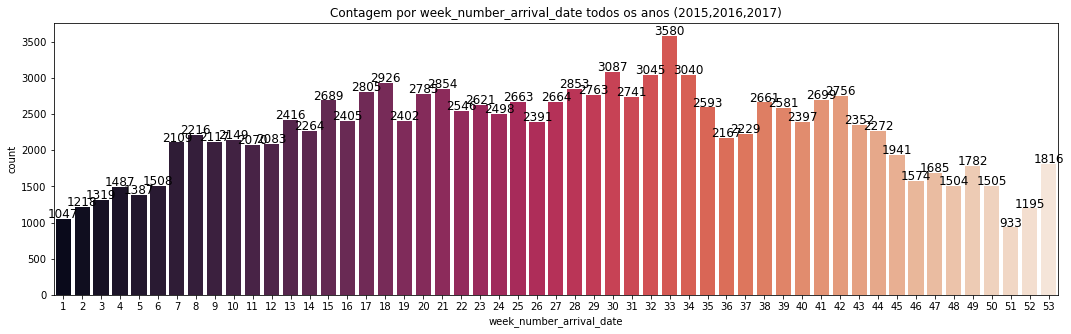

In [11]:
varqual(df, 'week_number_arrival_date', None)

day_of_month_arrival_date
******************************************************************************** 

17    3.69
5     3.62
15    3.51
25    3.48
26    3.47
9     3.43
12    3.42
16    3.42
2     3.40
19    3.39
20    3.38
18    3.35
24    3.34
28    3.31
8     3.28
3     3.23
30    3.23
6     3.21
14    3.20
27    3.18
21    3.16
4     3.15
13    3.14
7     3.07
1     3.04
23    3.03
11    3.01
22    3.01
29    3.00
10    2.99
31    1.85
Name: day_of_month_arrival_date, dtype: float64


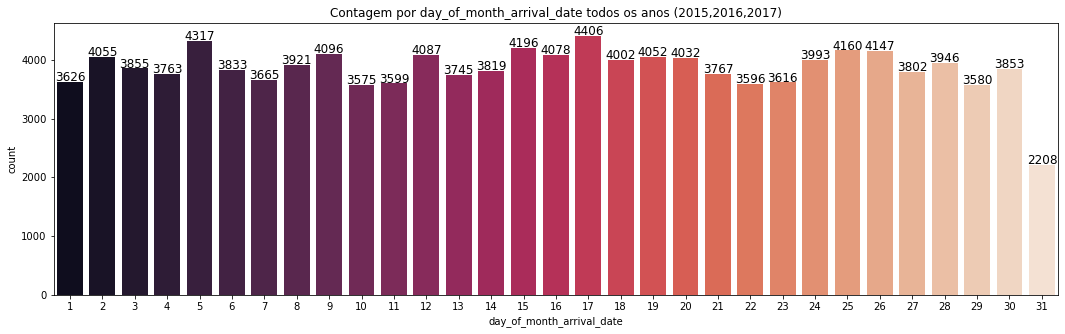

In [12]:
varqual(df, 'day_of_month_arrival_date', None)

breakfast
******************************************************************************** 

True     77.32
False    22.68
Name: breakfast, dtype: float64


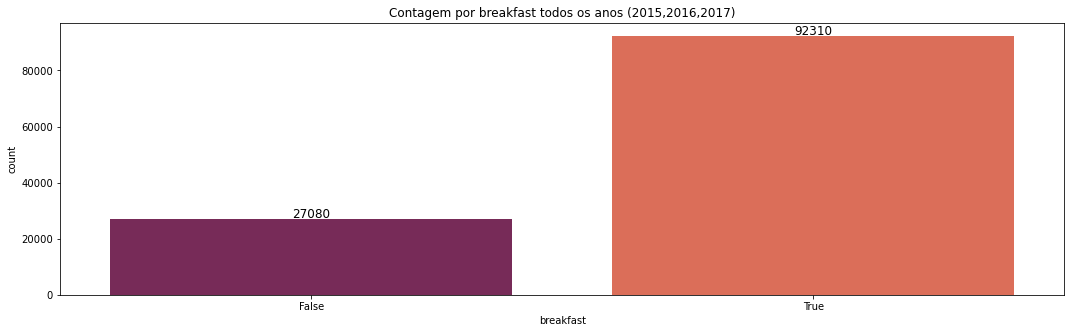

In [13]:
varqual(df, 'breakfast', None)

country
******************************************************************************** 

PRT    45.34
GBR    11.32
FRA     9.72
ESP     7.99
DEU     6.80
ITA     3.51
IRL     3.15
BEL     2.19
BRA     2.08
NLD     1.96
USA     1.96
CHE     1.61
CN      1.19
AUT     1.18
Name: country, dtype: float64


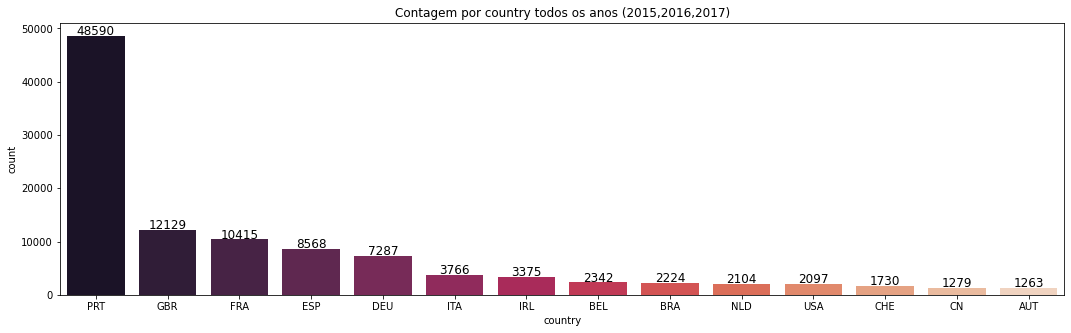

In [14]:
sel = df['country'].value_counts().index
sel = sel[:14]
df_c1 = df[df['country'].isin(sel)]

varqual(df_c1, 'country', sel)

market_segment
******************************************************************************** 

2    47.30
3    20.29
5    16.59
0    10.56
1     4.44
4     0.62
7     0.20
6     0.00
Name: market_segment, dtype: float64


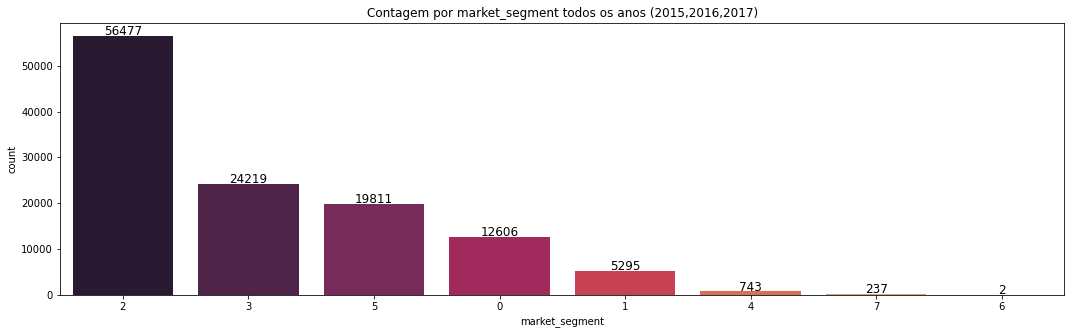

In [15]:
order = df['market_segment'].value_counts().index
varqual(df, 'market_segment', order)

distribution_channel
******************************************************************************** 

2    81.98
0    12.27
1     5.59
4     0.16
3     0.00
Name: distribution_channel, dtype: float64


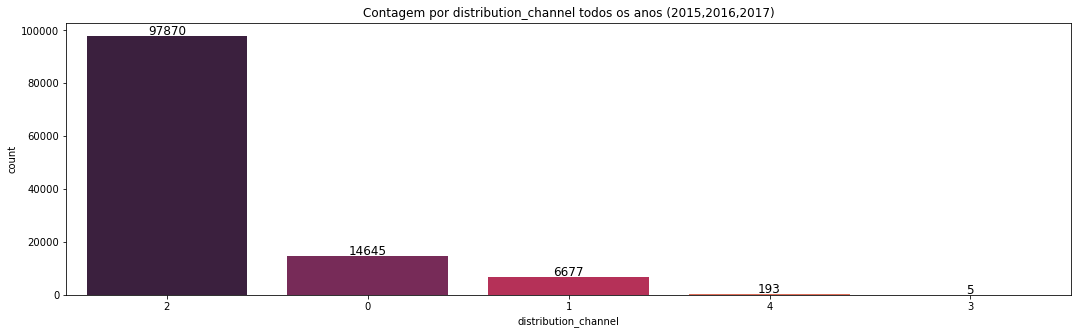

In [16]:
order = df['distribution_channel'].value_counts().index
varqual(df, 'distribution_channel', order)

repeated_guest
******************************************************************************** 

0    96.81
1     3.19
Name: repeated_guest, dtype: float64


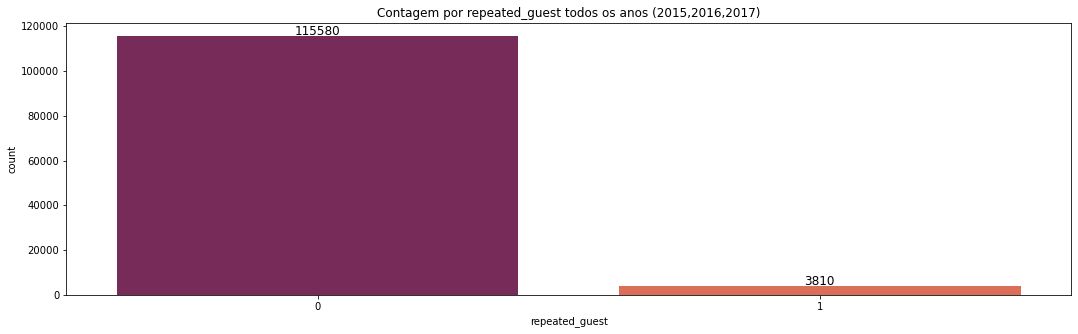

In [17]:
varqual(df, 'repeated_guest', None)

reserved_room
******************************************************************************** 

A    72.03
D    16.08
E     5.47
F     2.43
G     1.75
B     0.94
C     0.78
H     0.50
P     0.01
L     0.01
Name: reserved_room, dtype: float64


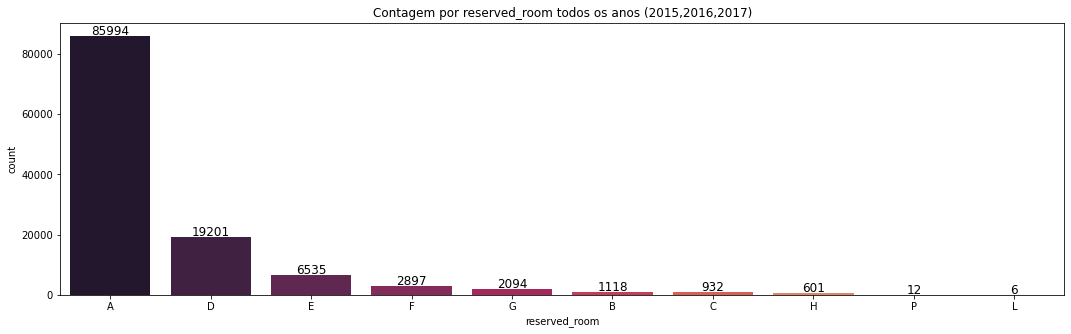

In [18]:
order = df['reserved_room'].value_counts().index
varqual(df, 'reserved_room', order)

deposit_policy
******************************************************************************** 

No Deposit    87.65
Non Refund    12.22
Refundable     0.14
Name: deposit_policy, dtype: float64


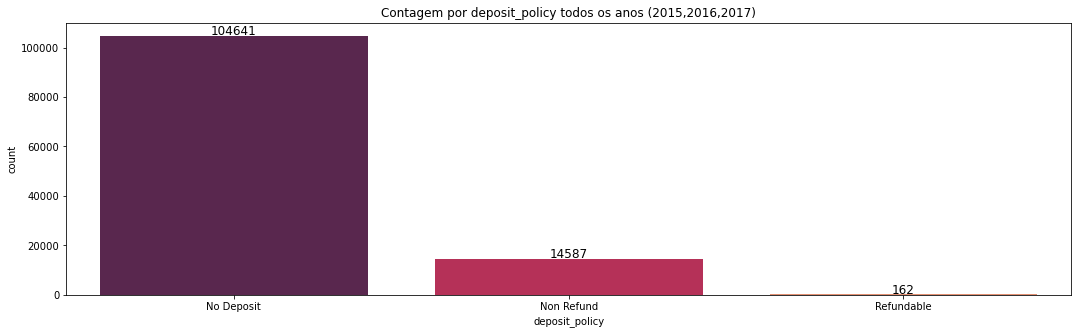

In [19]:
# Deposity Police
order = df['deposit_policy'].value_counts().index
varqual(df, 'deposit_policy', order)

customer_type
******************************************************************************** 

0    75.06
2    21.04
1     3.41
3     0.48
Name: customer_type, dtype: float64


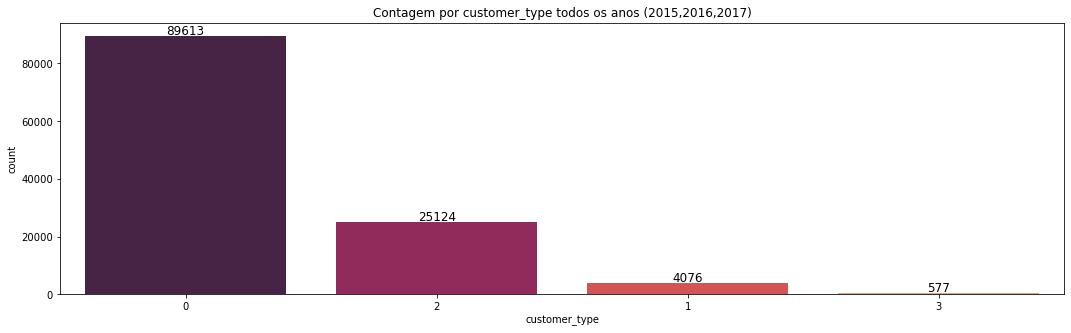

In [20]:
order = df['customer_type'].value_counts().index
varqual(df, 'customer_type', order)

###  ANÁLISE UNIVARIADA - VARIÁVEIS IDENTIFICADORAS

id_travel_agency_booking
******************************************************************************** 

9.0      42.07
240.0    18.32
1.0       9.46
14.0      4.79
7.0       4.66
6.0       4.33
250.0     3.78
241.0     2.27
28.0      2.19
8.0       1.99
3.0       1.76
37.0      1.62
19.0      1.40
40.0      1.37
Name: id_travel_agency_booking, dtype: float64


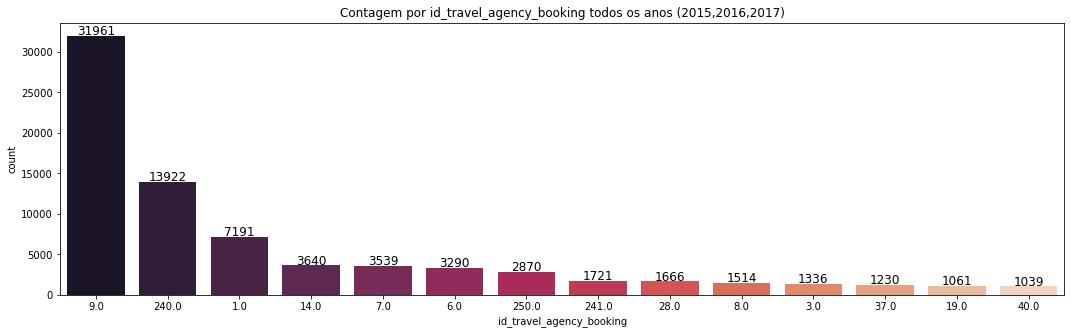

In [21]:
sel2 = df['id_travel_agency_booking'].value_counts().index
sel2 = sel2[:14]
df_c2 = df[df['id_travel_agency_booking'].isin(sel2)]

varqual(df_c2, 'id_travel_agency_booking', sel2)


id_person_booking
******************************************************************************** 

40.0     26.03
223.0    22.02
67.0      7.50
45.0      7.02
153.0     6.04
174.0     4.18
219.0     3.96
281.0     3.88
154.0     3.73
405.0     3.34
233.0     3.20
51.0      2.78
94.0      2.44
47.0      2.02
135.0     1.85
Name: id_person_booking, dtype: float64


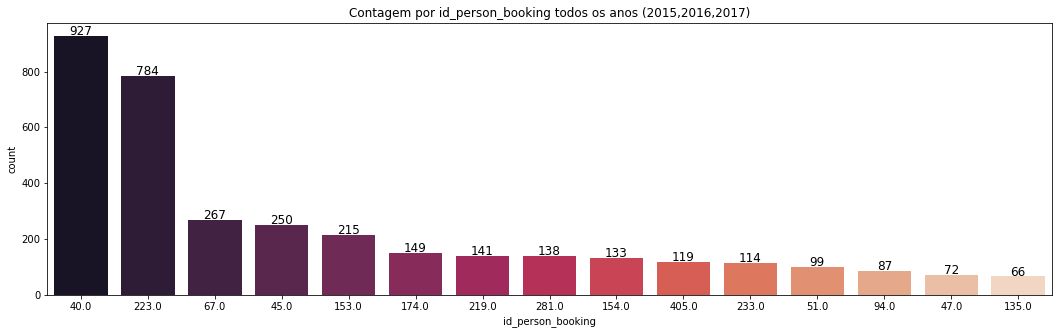

In [22]:
sel3 = df['id_person_booking'].value_counts().index
sel3 = sel3[:15]
df_c3 = df[df['id_person_booking'].isin(sel3)]

varqual(df_c3, 'id_person_booking', sel3)

### 2.1.2 - ANÁLISE UNIVARIADA - VARIÁVEIS QUANTITATIVAS

In [23]:

var_num = ['days_between_booking_arrival','num_weekend_nights',
           'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
           'num_previous_cancellations', 'num_previous_stays','changes_between_booking_arrival',
           'avg_price', 'required_car_parking_spaces','total_of_special_requests']

df[var_num].describe().round(2)

days_between_booking_arrival  num_weekend_nights  num_workweek_nights  \
count                     119390.00           119390.00            119390.00   
mean                         104.01                0.93                 2.50   
std                          106.86                1.00                 1.91   
min                            0.00                0.00                 0.00   
25%                           18.00                0.00                 1.00   
50%                           69.00                1.00                 2.00   
75%                          160.00                2.00                 3.00   
max                          737.00               19.00                50.00   

       num_adults  num_children  num_babies  num_previous_cancellations  \
count   119390.00      119386.0   119390.00                   119390.00   
mean         1.86           0.1        0.01                        0.09   
std          0.58           0.4        0.10                        0.84   
min          0.00           0.0        0.00                        0.00   
25%          2.00           0.0        0.00                        0.00   
50%          2.00           0.0        0.00                        0.00   
75%          2.00           0.0        0.00                        0.00   
max         55.00          10.0       10.00                       26.00   

       num_previous_stays  changes_between_booking_arrival  avg_price  \
count           119390.00                        119390.00  119390.00   
mean                 0.14                             0.22     101.72   
std                  1.50                             0.65      47.82   
min                  0.00                             0.00       0.00   
25%                  0.00                             0.00      69.29   
50%                  0.00                             0.00      94.58   
75%                  0.00                             0.00     126.00   
max                 72.00                            21.00     300.00   

       required_car_parking_spaces  total_of_special_requests  
count                    119390.00                  119390.00  
mean                          0.06                       0.57  
std                           0.25                       0.79  
min                           0.00                       0.00  
25%                           0.00                       0.00  
50%                           0.00                       0.00  
75%                           0.00                       1.00  
max                           8.00                       5.00

Describe ----- days_between_booking_arrival
count    119390.00
mean        104.01
std         106.86
min           0.00
25%          18.00
50%          69.00
75%         160.00
max         737.00
Name: days_between_booking_arrival, dtype: float64


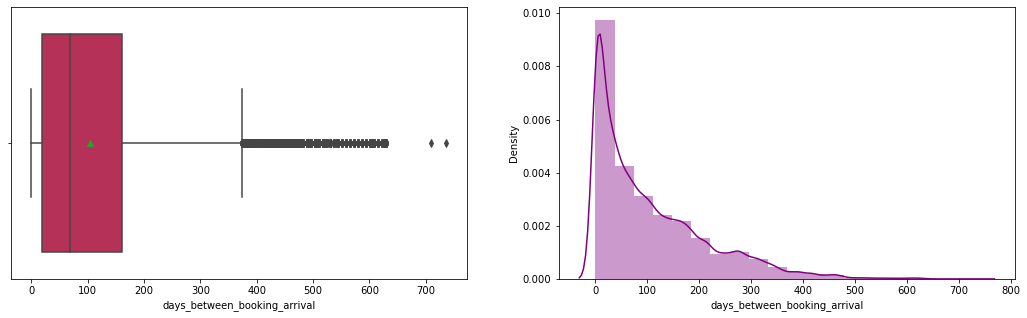

In [24]:
varnum(df,'days_between_booking_arrival')

Describe ----- avg_price
count    119390.00
mean        101.72
std          47.82
min           0.00
25%          69.29
50%          94.58
75%         126.00
max         300.00
Name: avg_price, dtype: float64


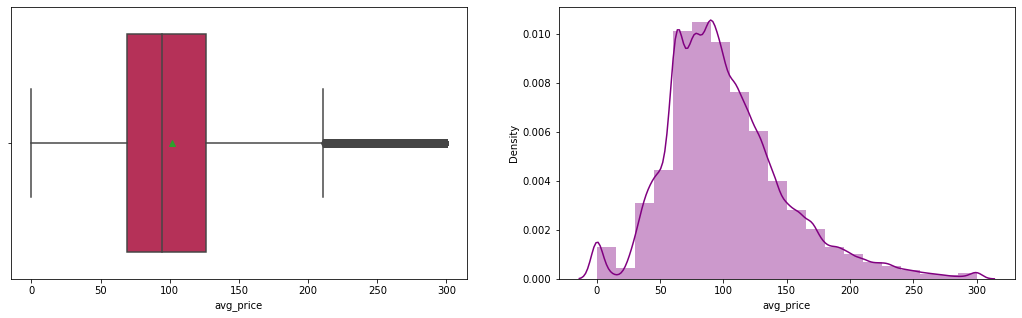

In [25]:
# Renda Mensal por quartis
varnum(df,'avg_price')

Describe ----- num_weekend_nights
count    119390.00
mean          0.93
std           1.00
min           0.00
25%           0.00
50%           1.00
75%           2.00
max          19.00
Name: num_weekend_nights, dtype: float64


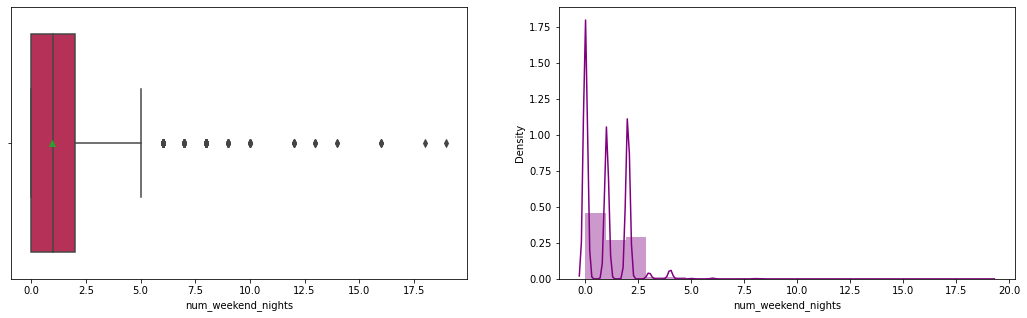

In [26]:
varnum(df, 'num_weekend_nights')

Describe ----- num_workweek_nights
count    119390.00
mean          2.50
std           1.91
min           0.00
25%           1.00
50%           2.00
75%           3.00
max          50.00
Name: num_workweek_nights, dtype: float64


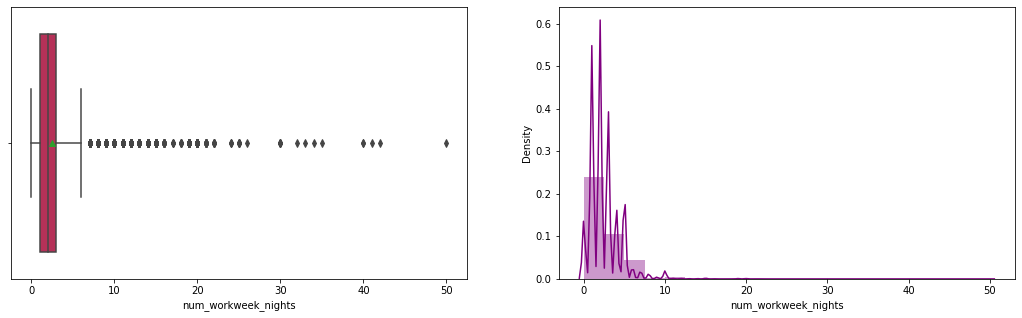

In [27]:
varnum(df, 'num_workweek_nights')

#### ANÁLISE UNIVARIADA - REPORT


**Análise:**

<font color='red'>1 - variáveis qualitativas (2015,2016,2017):</font>

- 37 % das reservas sao canceladas
- O ano de 2016 representa 47% das reservas
- A alta temporada se dá em Jul e Ago e o 1º é relativamente maior em nº de reservas
- A maioria das reservas possuem café da manha incluso 77%
- O país com maior nº de reservas é Portugual com 45%
- O seg de Mkt nº 2 tem a maior participaçao 47% , e canal de distribuicao nº 2 - é majoritário com 82%
- 87% das reservas nao exigem depósito antecipado

<font color='red'>2 - variáveis quantitativas (2015,2016,2017):</font>

- No geral baixo desvio-padrao, as features 'days_between_booking_arrival' e 'avg_price' como era esperado possuem um variancia maior entre os valores, o que pode indicar a presença de pouco outliers na base como um todo.

<font color='red'>3 - variáveis identificadoras (2015,2016,2017):</font>

- Alguns ids de agencia de viagens e da operador da reserva , possuem um concentraçao relevante em alguns ids o que podem gerar planos de açoes direcionados a estes se estes ids descriminarem a variável target


## 2.1.3 - ANÁLISE BIVARIADA - VARIÁVEIS QUALITATIVAS

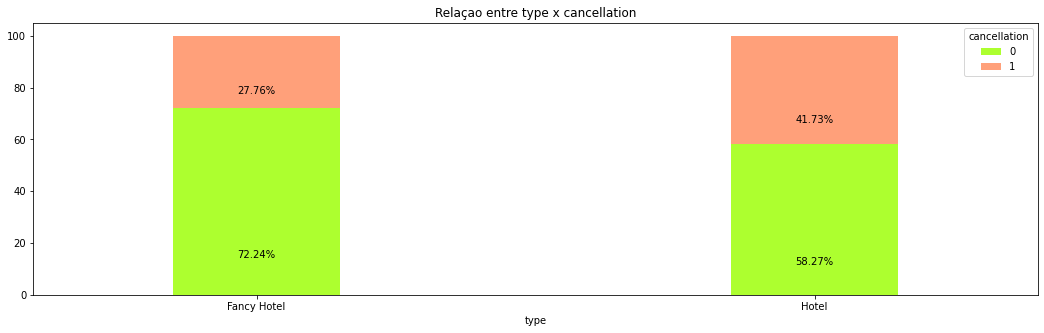

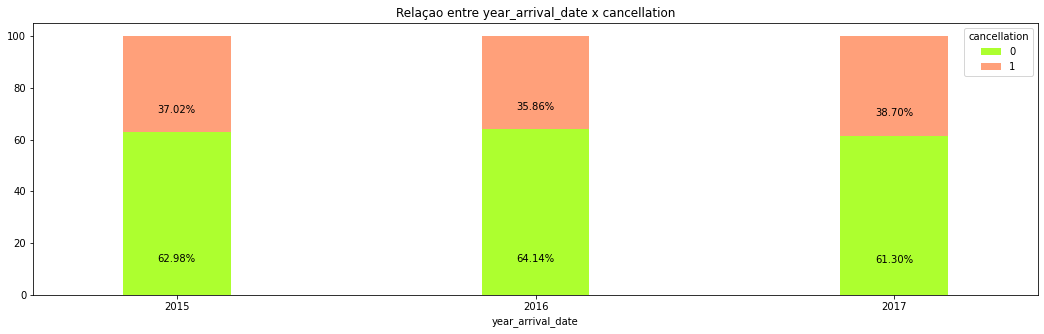

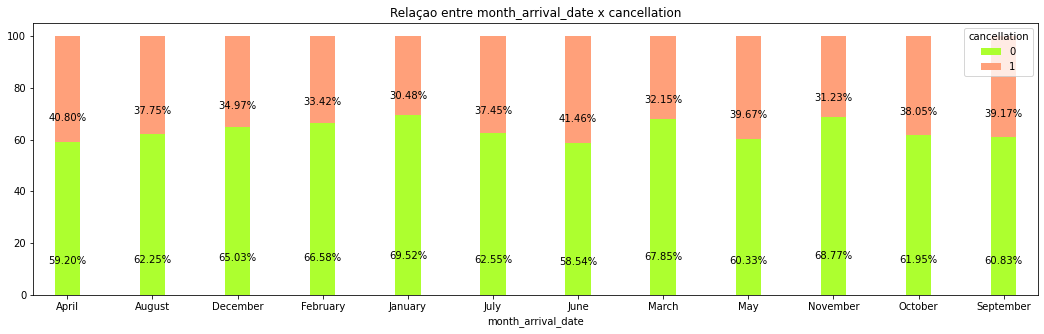

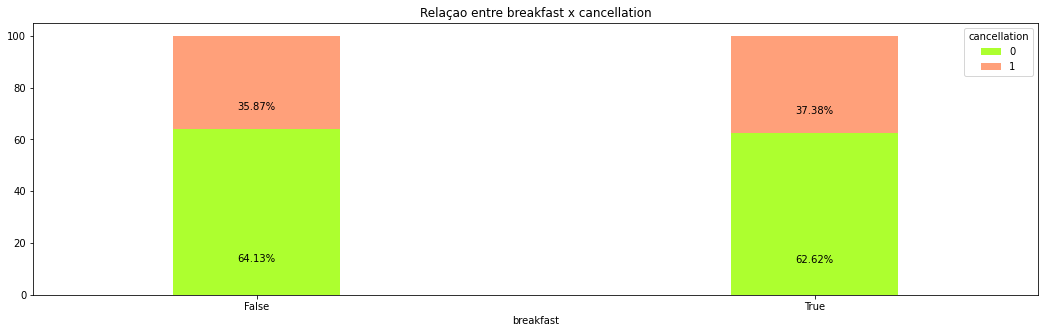

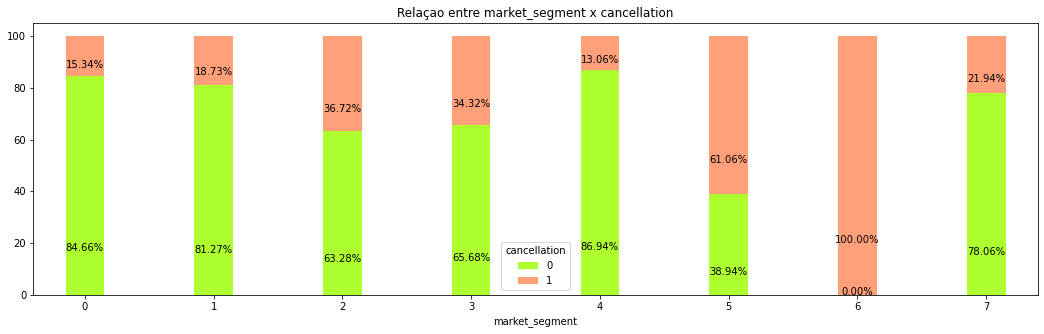

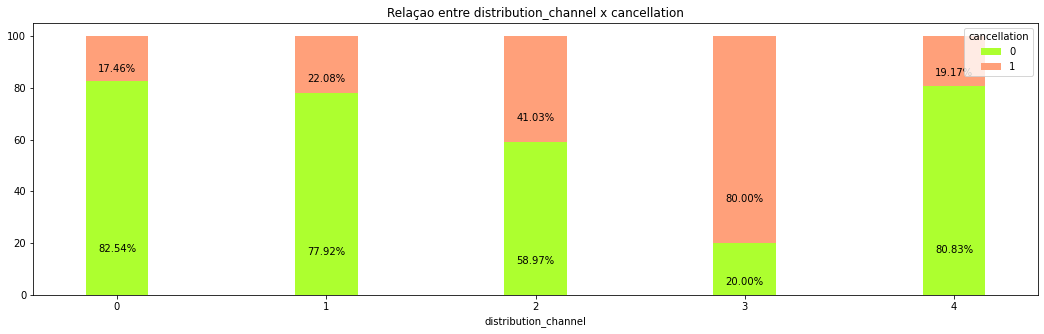

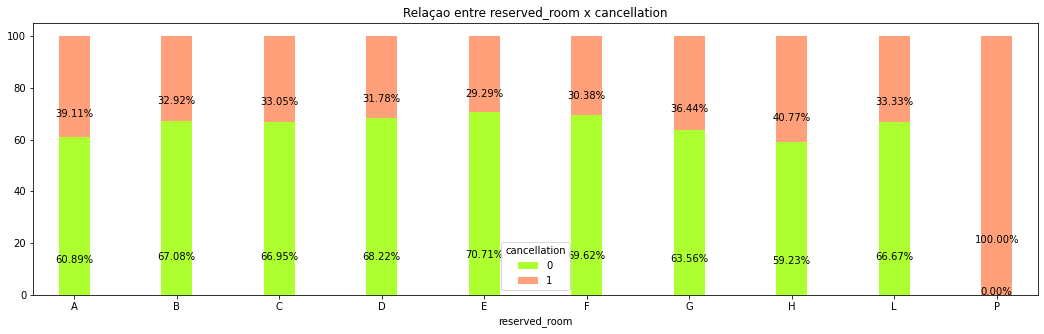

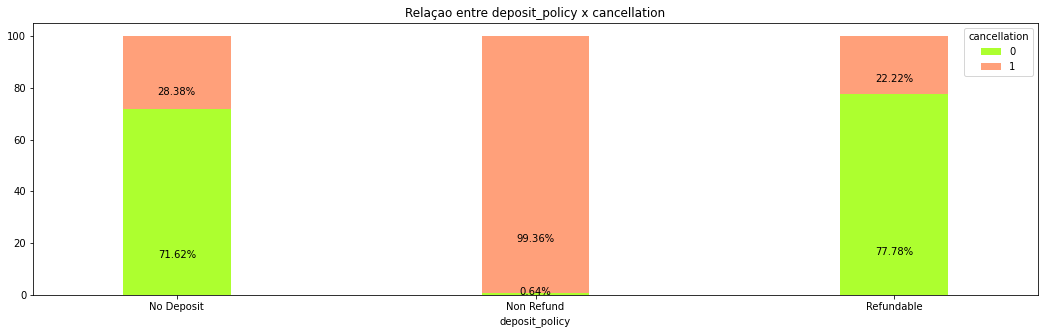

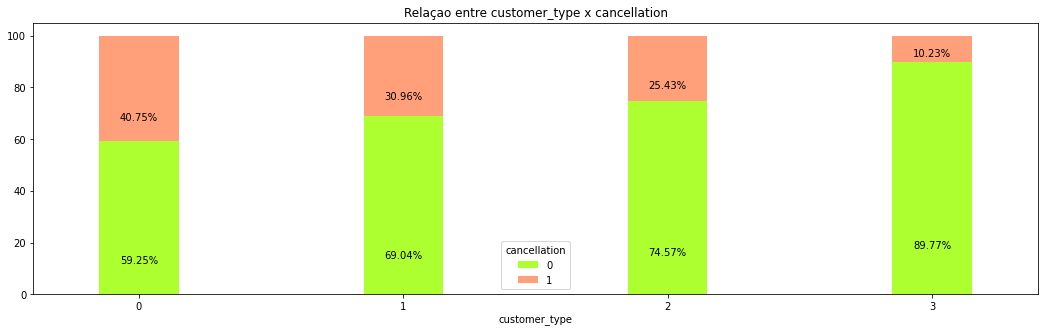

In [28]:
cols = ['type','year_arrival_date', 'month_arrival_date', 
       'breakfast', 'market_segment', 'distribution_channel',
       'reserved_room', 'deposit_policy','customer_type']

for col in cols:
    qual_qual(df, col, 'cancellation')
    

<font color='red'>Análise:</font> 

1 - A taxa de cancelamento dentro dos hotéis normais é 14% maior em absoluto frente ao hotéis de luxo

2 - Quase total do not refund dentro da feature deposit_police é cancelado

3 - O customer_type 0 tem a maior taxa de cancelamentos 40% dentro dos tipos de clientes


## 2.1.4 - ANÁLISE BIVARIADA - VARIÁVEIS QUANTITATIVAS

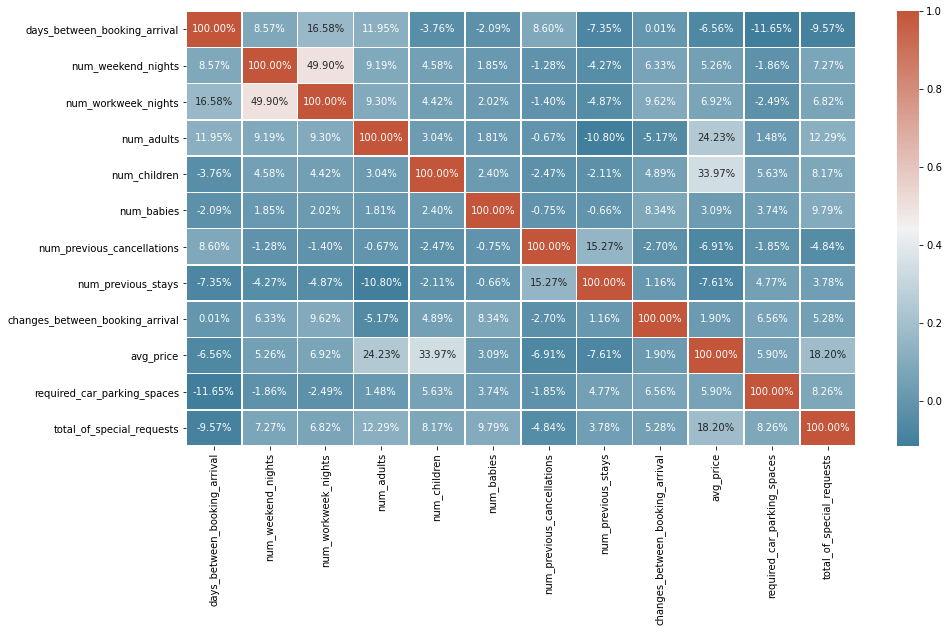

In [29]:
# Matriz de Correlação
fig = plt.subplots(figsize=(15,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
correlation = df[var_num].corr()
corrplot = sns.heatmap(correlation,cmap=cmap,annot=True, fmt='.2%', linewidths=.6)


<font color='red'>Análise:</font> 


1.   A média de preço aumenta em funçao do número de crianças e adultos aumenta
2.   As variavéis num_workweek_nights e num_weekend_nights sao correlacionadas
3.   A média de preço aumenta em funçao do número de total_of_special_requests
4.   Existe um correlacao leve positiva entre o espaço de dias entre a reserva e  a chegada com o número num_workweek_nights


## 2.1.5 - HIPÓTESES

<font color='red'>Hipóteses:</font> 


1.   Quanto maior for o intervalo entre a reserva e o checkin maior é taxa de cancelamento!
2.   As politicas de cancelamento (non refundable) tem baixa taxa de cancelamento.
3.   Hotéis de luxo cancelam menos que hotéis normais.
4.   Hotéis que recebem mais adultos com  bebes tem mais pedidos especiais
5.   A agencia de viagem com maior rentabilidade nao é a que vende mais reservas.
6.   Adultos sem crianças se hospedam mais na semana

### 1. Quanto maior for o intervalo entre a reserva e o checkin maior é taxa de cancelamento!

time_to_arrival
******************************************************************************** 

1m-3m to arrival      51.92
6m-1y to arrival      27.01
15d-30d to arrival     7.88
+1y to arrival         4.82
last minute            4.30
7d-15d to arrival      4.07
Name: time_to_arrival, dtype: float64


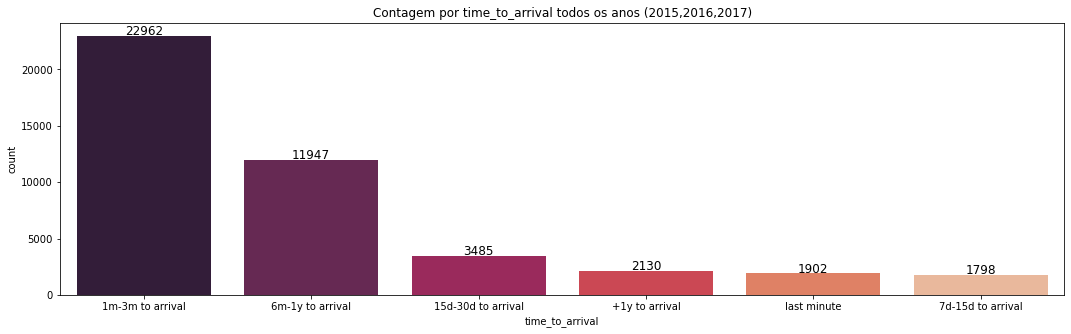

In [30]:
df_h1 = df[df['cancellation']==1]
df_h1.reset_index(inplace=True)

df_h1['time_to_arrival'] = ''

for i in range(len(df_h1)):
    if df_h1['days_between_booking_arrival'][i] < 8:
        df_h1['time_to_arrival'][i] = 'last minute'
    elif (df_h1['days_between_booking_arrival'][i] >7) & (df_h1['days_between_booking_arrival'][i]<16):        
        df_h1['time_to_arrival'][i] = '7d-15d to arrival'   
    elif (df_h1['days_between_booking_arrival'][i]>15) & (df_h1['days_between_booking_arrival'][i]<31):        
        df_h1['time_to_arrival'][i] = '15d-30d to arrival'
    elif (df_h1['days_between_booking_arrival'][i]>30) & (df_h1['days_between_booking_arrival'][i]<181):        
        df_h1['time_to_arrival'][i] = '1m-3m to arrival'
    elif (df_h1['days_between_booking_arrival'][i]>180) & (df_h1['days_between_booking_arrival'][i]<366):        
        df_h1['time_to_arrival'][i] = '6m-1y to arrival'
    else:        
        df_h1['time_to_arrival'][i] = '+1y to arrival'

order = df_h1['time_to_arrival'].value_counts().index        
varqual(df_h1,'time_to_arrival', order)          

### 2.   As politicas de cancelamento (Non refund) tem baixa taxa de cancelamento.

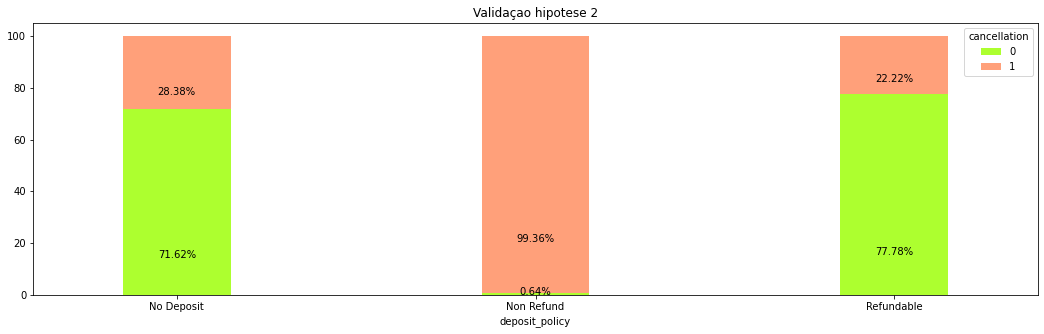

deposit_policy  No Deposit  Non Refund  Refundable
cancellation                                      
0                    71.62        0.64       77.78
1                    28.38       99.36       22.22

In [31]:
h2 = df.groupby([df['deposit_policy'],df['cancellation']]).size().unstack()

ax = (h2.T*100/h2.T.sum()).T.plot(kind='bar',
figsize=(18,5),width=0.3, color=['greenyellow','lightsalmon'],stacked=True, rot=0)
ax.set_title('Validaçao hipotese 2')
    
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x ,y = p.get_xy()
    ax.annotate('{:.2f}%'.format(height), (x + width/2, y + height*0.2), ha='center') 
     
plt.show() 

h2 = ((h2.T*100/h2.T.sum())).round(2)
h2

In [32]:
df['deposit_policy'].value_counts(normalize=True)

No Deposit    0.876464
Non Refund    0.122179
Refundable    0.001357
Name: deposit_policy, dtype: float64

### 3.   Hotéis de luxo cancelam menos que hotéis normais.

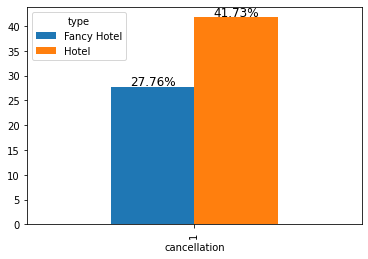

In [33]:
h3 = df.groupby([df['type'],df['cancellation']]).size().unstack()
h3 = (h3.T*100/h3.T.sum())
h3 = h3.tail(1)

ax=h3.plot(kind='bar')
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(i.get_height()),
        (i.get_x() + i.get_width() / 2, i.get_height()),
        ha='center',
        va='baseline',
        fontsize=12,
        color='black',
        xytext=(0, 1),
        textcoords='offset points')    
plt.show()

### 4.   Hotéis que recebem mais adultos com bebes tem mais pedidos especiais

            total_of_special_requests
num_babies                           
0                               66807
1                                1379
2                                  28
9                                   0
10                                  1
num_babies
******************************************************************************** 

0     99.23
1      0.75
2      0.01
9      0.00
10     0.00
Name: num_babies, dtype: float64


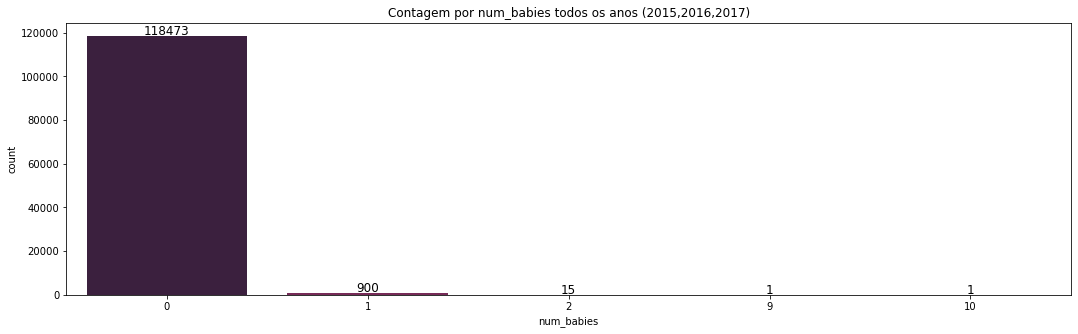

In [34]:
h4 = df.groupby('num_babies')['total_of_special_requests'].sum()
print(pd.DataFrame(h4))
varqual(df,'num_babies',None)

### 5.   A agencia de viagem com maior rentabilidade (desconsiderando cancelamentos) nao é a que vende mais reservas(top10).

id_travel_agency_booking
250.0    129.533797
14.0     125.228648
9.0      122.781392
240.0    108.743745
8.0      107.031178
241.0     97.096330
7.0       94.299915
6.0       89.126985
28.0      79.280219
1.0       73.994474
Name: avg_price, dtype: float64

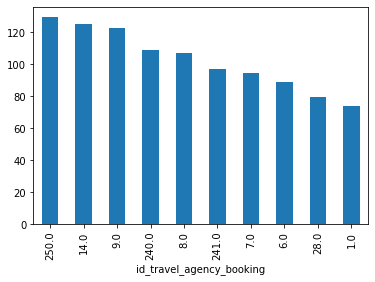

In [35]:
ag_top10 = (df['id_travel_agency_booking'].value_counts().head(10)).index

h5 = df[(df['cancellation']==0)& df['id_travel_agency_booking'].isin(ag_top10)]
h5 = h5.groupby('id_travel_agency_booking')['avg_price'].mean()
h5 = h5.sort_values(ascending=False).head(10)
h5.plot(kind='bar')
h5

### 6.   Adultos sem crianças se hospedam mais na semana em média

In [36]:
h6 = df
h6['no_kids'] = ''

for i in range(len(h6)):
    if (h6['num_children'][i] == 0) and (h6['num_babies'][i] == 0):
        h6['no_kids'][i] = 1
    else:
        h6['no_kids'][i] = 0

In [37]:
h7 = h6.groupby('no_kids')['num_workweek_nights'].mean()
h7

no_kids
0    2.828728
1    2.472441
Name: num_workweek_nights, dtype: float64

# **3 - PREPARAÇAO DA BASE DE DADOS**

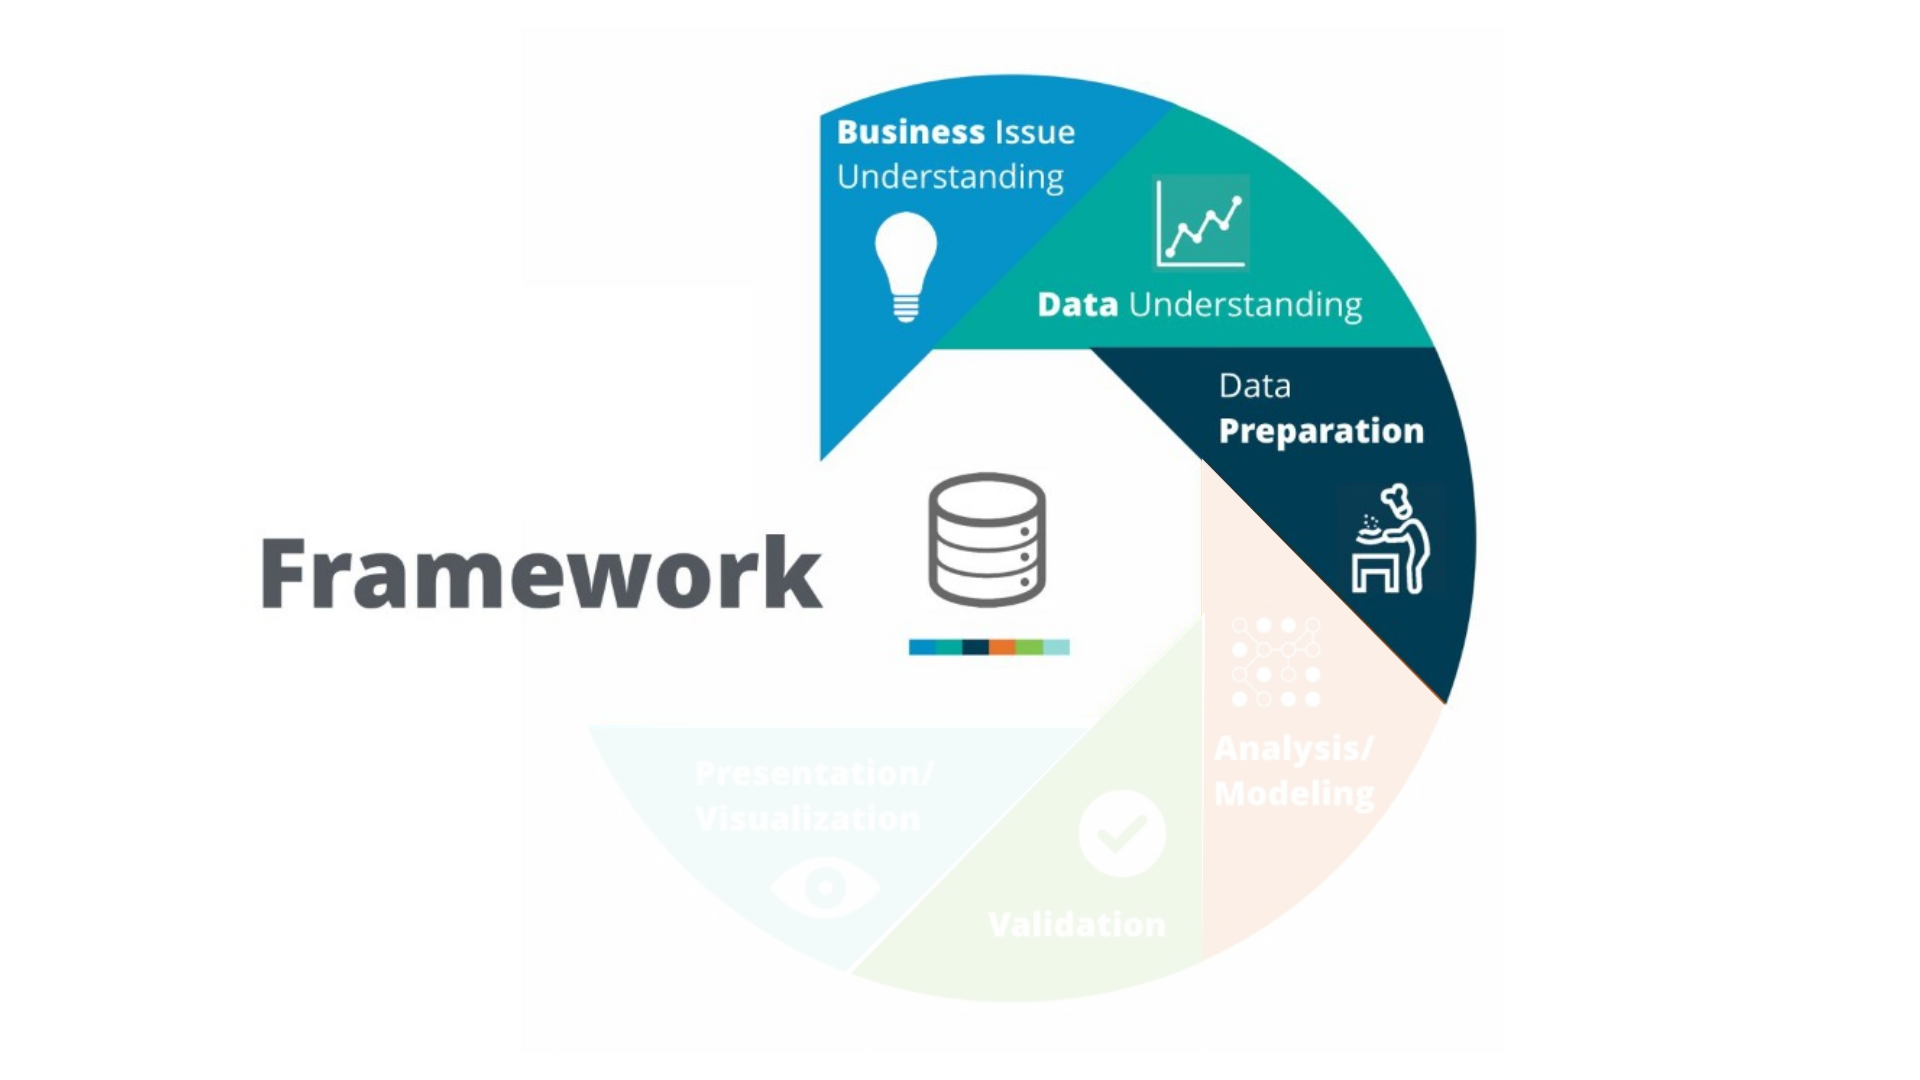

## 3.1 - LIMPEZA E TRANSFORMAÇÃO DOS DADOS

## Missings

In [38]:
#Review dos dados
info(df)

PRINCIPAIS INFORMAÇÕES DO DATASET 

******************************************************************************** 

Shape: (119390, 29) 

******************************************************************************** 

Types 

type                                object
cancellation                         int64
days_between_booking_arrival         int64
year_arrival_date                    int64
month_arrival_date                  object
week_number_arrival_date             int64
day_of_month_arrival_date            int64
num_weekend_nights                   int64
num_workweek_nights                  int64
num_adults                           int64
num_children                       float64
num_babies                           int64
breakfast                             bool
country                             object
market_segment                       int64
distribution_channel                 int64
repeated_guest                       int64
num_previous_cancellations           

In [39]:
## Açao

# 1- Eliminar a coluna id_person_booking, pois a mesmo possui 94% de missing
df1 = df.drop(columns ='id_person_booking' ,axis = 1)

# 2 - Para a coluna id_travel_agency_booking realizar imputaçao
values = {"id_travel_agency_booking": 0.0}
df1.fillna(value=values ,inplace=True)

# 3- Eliminar o missing das colunas (num_children,country), por que a exclusao afeta pouco o dataset
# em termos de quantidade de obs
df1.dropna(axis=0, inplace=True)
df1.reset_index(inplace=True, drop=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118898 entries, 0 to 118897
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             118898 non-null  object 
 1   cancellation                     118898 non-null  int64  
 2   days_between_booking_arrival     118898 non-null  int64  
 3   year_arrival_date                118898 non-null  int64  
 4   month_arrival_date               118898 non-null  object 
 5   week_number_arrival_date         118898 non-null  int64  
 6   day_of_month_arrival_date        118898 non-null  int64  
 7   num_weekend_nights               118898 non-null  int64  
 8   num_workweek_nights              118898 non-null  int64  
 9   num_adults                       118898 non-null  int64  
 10  num_children                     118898 non-null  float64
 11  num_babies                       118898 non-null  int64  
 12  br

### Eliminando os outliers

In [40]:
cols = ['days_between_booking_arrival','avg_price']
df2 = df1 

for col in cols:
    fator = 1.5

    q3 = df1[col].quantile(.75)
    q1 = df1[col].quantile(.25)

    iqr = q3 - q1

    lowpass = q1 - (iqr * fator)

    highpass = q3 + (iqr * fator)


    df2 = df2[(df2[col] < highpass)]


In [41]:
df2['num_weekend_nights'].value_counts(normalize=True).head(10)

0    0.431906
2    0.278721
1    0.260546
4    0.015664
3    0.010160
6    0.001340
5    0.000697
8    0.000518
7    0.000170
9    0.000098
Name: num_weekend_nights, dtype: float64

In [42]:
df2 = df2[(df2['num_weekend_nights'] < 5)]

In [43]:
df2['num_workweek_nights'].value_counts(normalize=True).head(10)

2     0.279023
1     0.256688
3     0.188528
5     0.092530
4     0.080224
0     0.065355
6     0.012395
7     0.008568
10    0.008550
8     0.005476
Name: num_workweek_nights, dtype: float64

In [44]:
df2 = df2[(df2['num_workweek_nights'] < 7)]

In [45]:
df2['num_adults'].value_counts(normalize=True).head(10)

2     0.746977
1     0.200851
3     0.048346
0     0.003356
4     0.000322
26    0.000046
5     0.000018
20    0.000018
27    0.000018
6     0.000009
Name: num_adults, dtype: float64

In [46]:
df2 = df2[(df2['num_adults'] < 4)]

In [47]:
df2 = df2[(df2['num_babies'] < 2)]

In [48]:
df2['num_previous_cancellations'].value_counts(normalize=True).head(10)

0     0.943116
1     0.052947
2     0.001030
3     0.000598
24    0.000442
11    0.000322
4     0.000276
26    0.000239
25    0.000230
6     0.000202
Name: num_previous_cancellations, dtype: float64

In [49]:
df2 = df2[(df2['num_previous_cancellations'] < 4)]

In [50]:
df2['num_previous_stays'].value_counts(normalize=True).head(10)

0    0.970823
1    0.012458
2    0.004740
3    0.002711
4    0.001798
5    0.001512
6    0.001014
7    0.000756
8    0.000609
9    0.000526
Name: num_previous_stays, dtype: float64

In [51]:
df2 = df2[(df2['num_previous_stays'] < 3)]

In [52]:
df2['changes_between_booking_arrival'].value_counts(normalize=True).head(10)

0    0.853291
1    0.103254
2    0.031154
3    0.007439
4    0.002996
5    0.000877
6    0.000392
7    0.000252
8    0.000112
9    0.000056
Name: changes_between_booking_arrival, dtype: float64

In [53]:
df2 = df2[(df2['changes_between_booking_arrival'] < 4)]

In [54]:
df2['required_car_parking_spaces'].value_counts(normalize=True).head(10)

0    0.941617
1    0.058158
2    0.000188
3    0.000019
8    0.000019
Name: required_car_parking_spaces, dtype: float64

In [55]:
df2 = df2[(df2['required_car_parking_spaces'] < 3)]

In [56]:
df2[var_num].describe().round(2)

days_between_booking_arrival  num_weekend_nights  num_workweek_nights  \
count                     106619.00           106619.00            106619.00   
mean                          95.74                0.86                 2.31   
std                           92.74                0.87                 1.42   
min                            0.00                0.00                 0.00   
25%                           18.00                0.00                 1.00   
50%                           67.00                1.00                 2.00   
75%                          152.00                2.00                 3.00   
max                          374.00                4.00                 6.00   

       num_adults  num_children  num_babies  num_previous_cancellations  \
count   106619.00     106619.00   106619.00                   106619.00   
mean         1.85          0.08        0.01                        0.05   
std          0.48          0.35        0.08                        0.23   
min          0.00          0.00        0.00                        0.00   
25%          2.00          0.00        0.00                        0.00   
50%          2.00          0.00        0.00                        0.00   
75%          2.00          0.00        0.00                        0.00   
max          3.00          3.00        1.00                        3.00   

       num_previous_stays  changes_between_booking_arrival  avg_price  \
count           106619.00                        106619.00  106619.00   
mean                 0.02                             0.19      98.12   
std                  0.18                             0.51      40.17   
min                  0.00                             0.00       0.00   
25%                  0.00                             0.00      70.00   
50%                  0.00                             0.00      94.50   
75%                  0.00                             0.00     123.00   
max                  2.00                             3.00     209.86   

       required_car_parking_spaces  total_of_special_requests  
count                    106619.00                  106619.00  
mean                          0.06                       0.56  
std                           0.24                       0.78  
min                           0.00                       0.00  
25%                           0.00                       0.00  
50%                           0.00                       0.00  
75%                           0.00                       1.00  
max                           2.00                       5.00

# **4 - ANÁLISE E MODELAGEM**

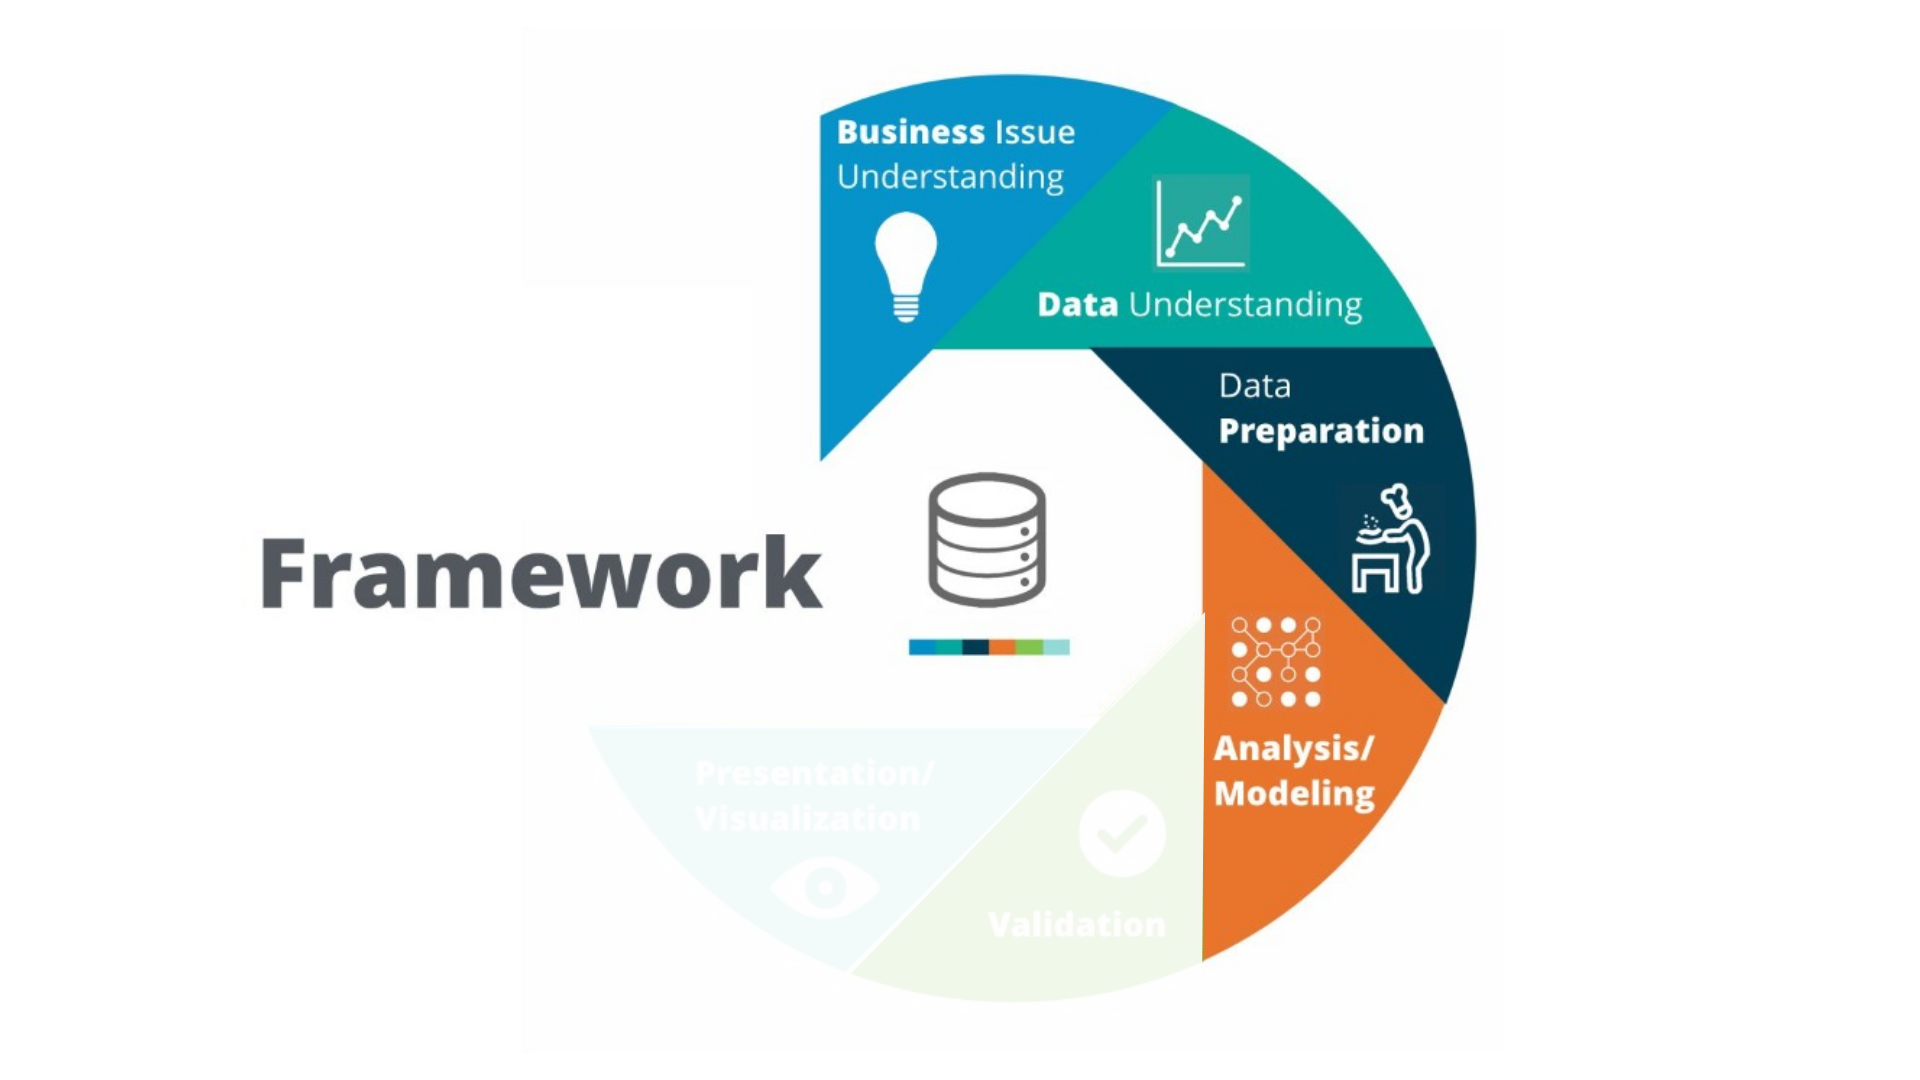

### Categorical enconding

In [57]:
df2 = df2[['type', 'cancellation', 'days_between_booking_arrival',
       'year_arrival_date', 'month_arrival_date', 'week_number_arrival_date',
       'day_of_month_arrival_date', 'num_weekend_nights',
       'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
       'breakfast', 'country', 'market_segment', 'distribution_channel',
       'repeated_guest', 'num_previous_cancellations', 'num_previous_stays',
       'reserved_room', 'changes_between_booking_arrival', 'deposit_policy',
       'id_travel_agency_booking', 'customer_type', 'avg_price',
       'required_car_parking_spaces', 'total_of_special_requests']]

In [58]:
#Label encoding
df3 = df2
label_encoder = ['year_arrival_date', 'month_arrival_date','country','reserved_room']
labelencoder = LabelEncoder()
for i in label_encoder:
    df3[ i +'_cat'] = labelencoder.fit_transform(df3[i])

In [59]:
# One hot encoding
one_hot_encoder = ['type', 'breakfast','repeated_guest','deposit_policy']
for i in one_hot_encoder:
    df3 = pd.get_dummies(df3, columns=[i], prefix=[i+'_'] )

In [60]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106619 entries, 0 to 118896
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   cancellation                     106619 non-null  int64  
 1   days_between_booking_arrival     106619 non-null  int64  
 2   year_arrival_date                106619 non-null  int64  
 3   month_arrival_date               106619 non-null  object 
 4   week_number_arrival_date         106619 non-null  int64  
 5   day_of_month_arrival_date        106619 non-null  int64  
 6   num_weekend_nights               106619 non-null  int64  
 7   num_workweek_nights              106619 non-null  int64  
 8   num_adults                       106619 non-null  int64  
 9   num_children                     106619 non-null  float64
 10  num_babies                       106619 non-null  int64  
 11  country                          106619 non-null  object 
 12  ma

In [61]:
df4 = df3[['cancellation', 'days_between_booking_arrival',
           'week_number_arrival_date','day_of_month_arrival_date', 'num_weekend_nights',
           'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
           'market_segment', 'distribution_channel','num_previous_cancellations',
           'num_previous_stays','changes_between_booking_arrival', 'id_travel_agency_booking',
           'customer_type', 'avg_price', 'required_car_parking_spaces',
           'total_of_special_requests', 'year_arrival_date_cat',
           'month_arrival_date_cat', 'country_cat', 'reserved_room_cat',
           'type__Fancy Hotel', 'type__Hotel', 'breakfast__False',
           'breakfast__True', 'repeated_guest__0', 'repeated_guest__1',
           'deposit_policy__No Deposit', 'deposit_policy__Non Refund',
           'deposit_policy__Refundable']]

In [62]:
df4.head()

cancellation  days_between_booking_arrival  week_number_arrival_date  \
0             0                           342                        27   
2             0                             7                        27   
3             0                            13                        27   
4             0                            14                        27   
5             0                            14                        27   

   day_of_month_arrival_date  num_weekend_nights  num_workweek_nights  \
0                          1                   0                    0   
2                          1                   0                    1   
3                          1                   0                    1   
4                          1                   0                    2   
5                          1                   0                    2   

   num_adults  num_children  num_babies  market_segment  ...  \
0           2           0.0           0               0  ...   
2           1           0.0           0               0  ...   
3           1           0.0           0               1  ...   
4           2           0.0           0               2  ...   
5           2           0.0           0               2  ...   

   reserved_room_cat  type__Fancy Hotel  type__Hotel  breakfast__False  \
0                  2                  1            0                 0   
2                  0                  1            0                 0   
3                  0                  1            0                 0   
4                  0                  1            0                 0   
5                  0                  1            0                 0   

   breakfast__True  repeated_guest__0  repeated_guest__1  \
0                1                  1                  0   
2                1                  1                  0   
3                1                  1                  0   
4                1                  1                  0   
5                1                  1                  0   

   deposit_policy__No Deposit  deposit_policy__Non Refund  \
0                           1                           0   
2                           1                           0   
3                           1                           0   
4                           1                           0   
5                           1                           0   

   deposit_policy__Refundable  
0                           0  
2                           0  
3                           0  
4                           0  
5                           0  

[5 rows x 32 columns]

### Separando em X , Y

In [66]:
#Aleatório
X = df4.drop('cancellation', axis=1)
y = df4['cancellation']

# Temporal
df5 = df4[df4['year_arrival_date_cat']<2]
X2 = df5.drop('cancellation', axis=1)
y2 = df5['cancellation']

df6 = df4[df4['year_arrival_date_cat']==2]
X2_test = df6.drop('cancellation', axis=1)
y2_test = df6['cancellation']

### Padronizaçao/ Normalizacao

In [68]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X2 = scaler.fit_transform(X2)


### Divisao entre treino e teste

In [69]:
#Aleatório
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

In [70]:
# Temporal
X2_train = X2
y2_train = y2

### Banlanceamento

In [71]:
y.value_counts(normalize=True)

0    0.632561
1    0.367439
Name: cancellation, dtype: float64

In [72]:
y2.value_counts(normalize=True)

0    0.641922
1    0.358078
Name: cancellation, dtype: float64

In [73]:
#SMOTE na base de treino - escolhido
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())

0    50582
1    50582
Name: cancellation, dtype: int64


In [74]:
#SMOTE na base de treino - escolhido
smote = SMOTE()
X_res2, y_res2 = smote.fit_resample(X2_train, y2_train)

# ver o balanceamento das classes
print(pd.Series(y_res2).value_counts())

0    45918
1    45918
Name: cancellation, dtype: int64


# **5 - VALIDAÇÃO DO MODELO**


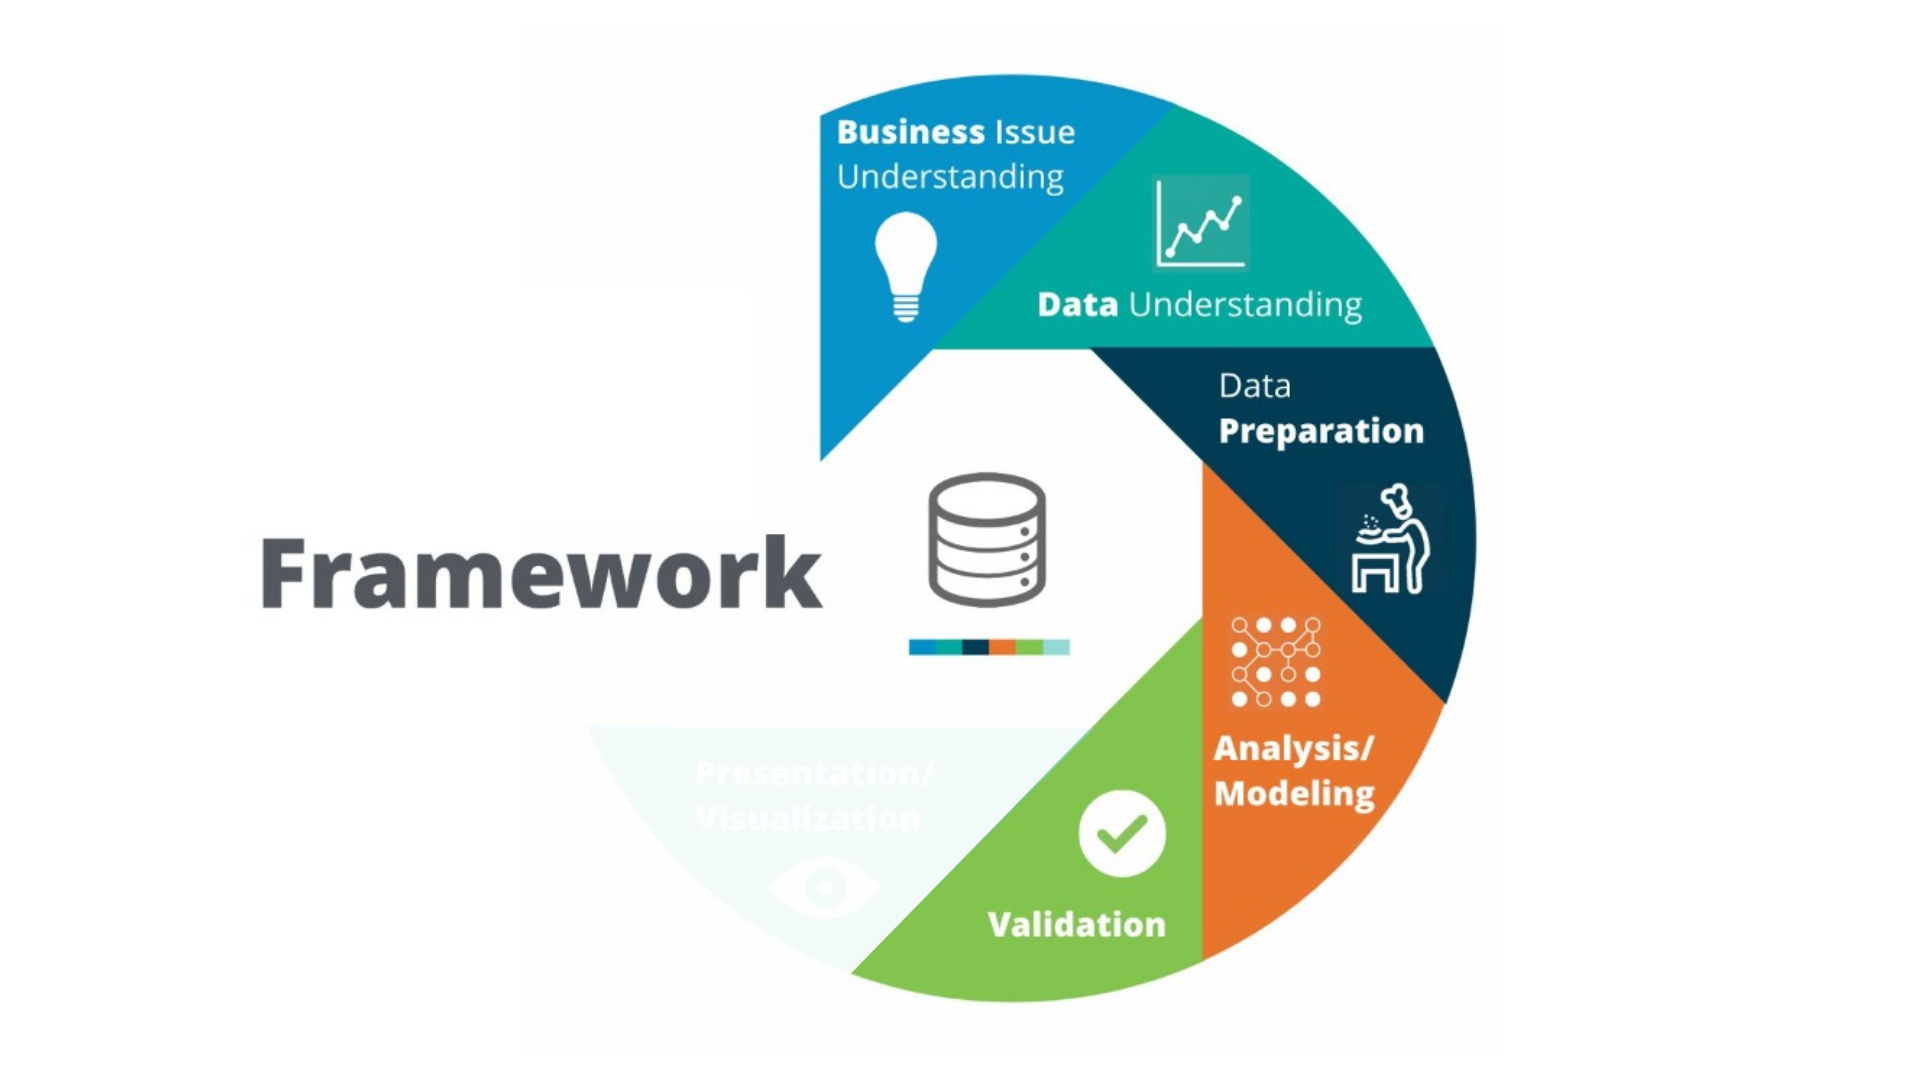

Serão usados 4 modelos para cada dataset, totalizando 20 modelos que ao final será escolhido o melhor para cada Performance

Algoritmos para treinar modelos:

*   Regressão Logística
*   Árvores de Decisão
*   Random Forest
*   XGBoost

Como métricas serão a Acurácia, Precisão, Recall, Área sob a Curva ROC

## TREINO 

In [80]:
#Criando os modelos juntamente com as métricas

#Regressão logística
logreg = cross_validate(LogisticRegression(solver='liblinear'), X_res, y_res, cv=5, 
                        scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

#Arvóres de decisão
trees = cross_validate(DecisionTreeClassifier(), X_res, y_res, cv=5, 
                       scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

# Random Forest
forest = cross_validate(RandomForestClassifier(), X_res, y_res, cv=5, 
                        scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

#XGBoost
xgb = cross_validate(XGBClassifier(), X_res, y_res, cv=5, 
                     scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

[04:28:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:28:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:28:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:28:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [81]:
#Criando os modelos juntamente com as métricas

#Regressão logística
logreg2 = cross_validate(LogisticRegression(solver='liblinear'), X_res2, y_res2, cv=5, 
                        scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

#Arvóres de decisão
trees2 = cross_validate(DecisionTreeClassifier(), X_res2, y_res2, cv=5, 
                       scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

# Random Forest
forest2 = cross_validate(RandomForestClassifier(), X_res2, y_res2, cv=5, 
                        scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

#XGBoost
xgb2 = cross_validate(XGBClassifier(), X_res2, y_res2, cv=5, 
                     scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

[04:29:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

# **6 - RESULTADOS**

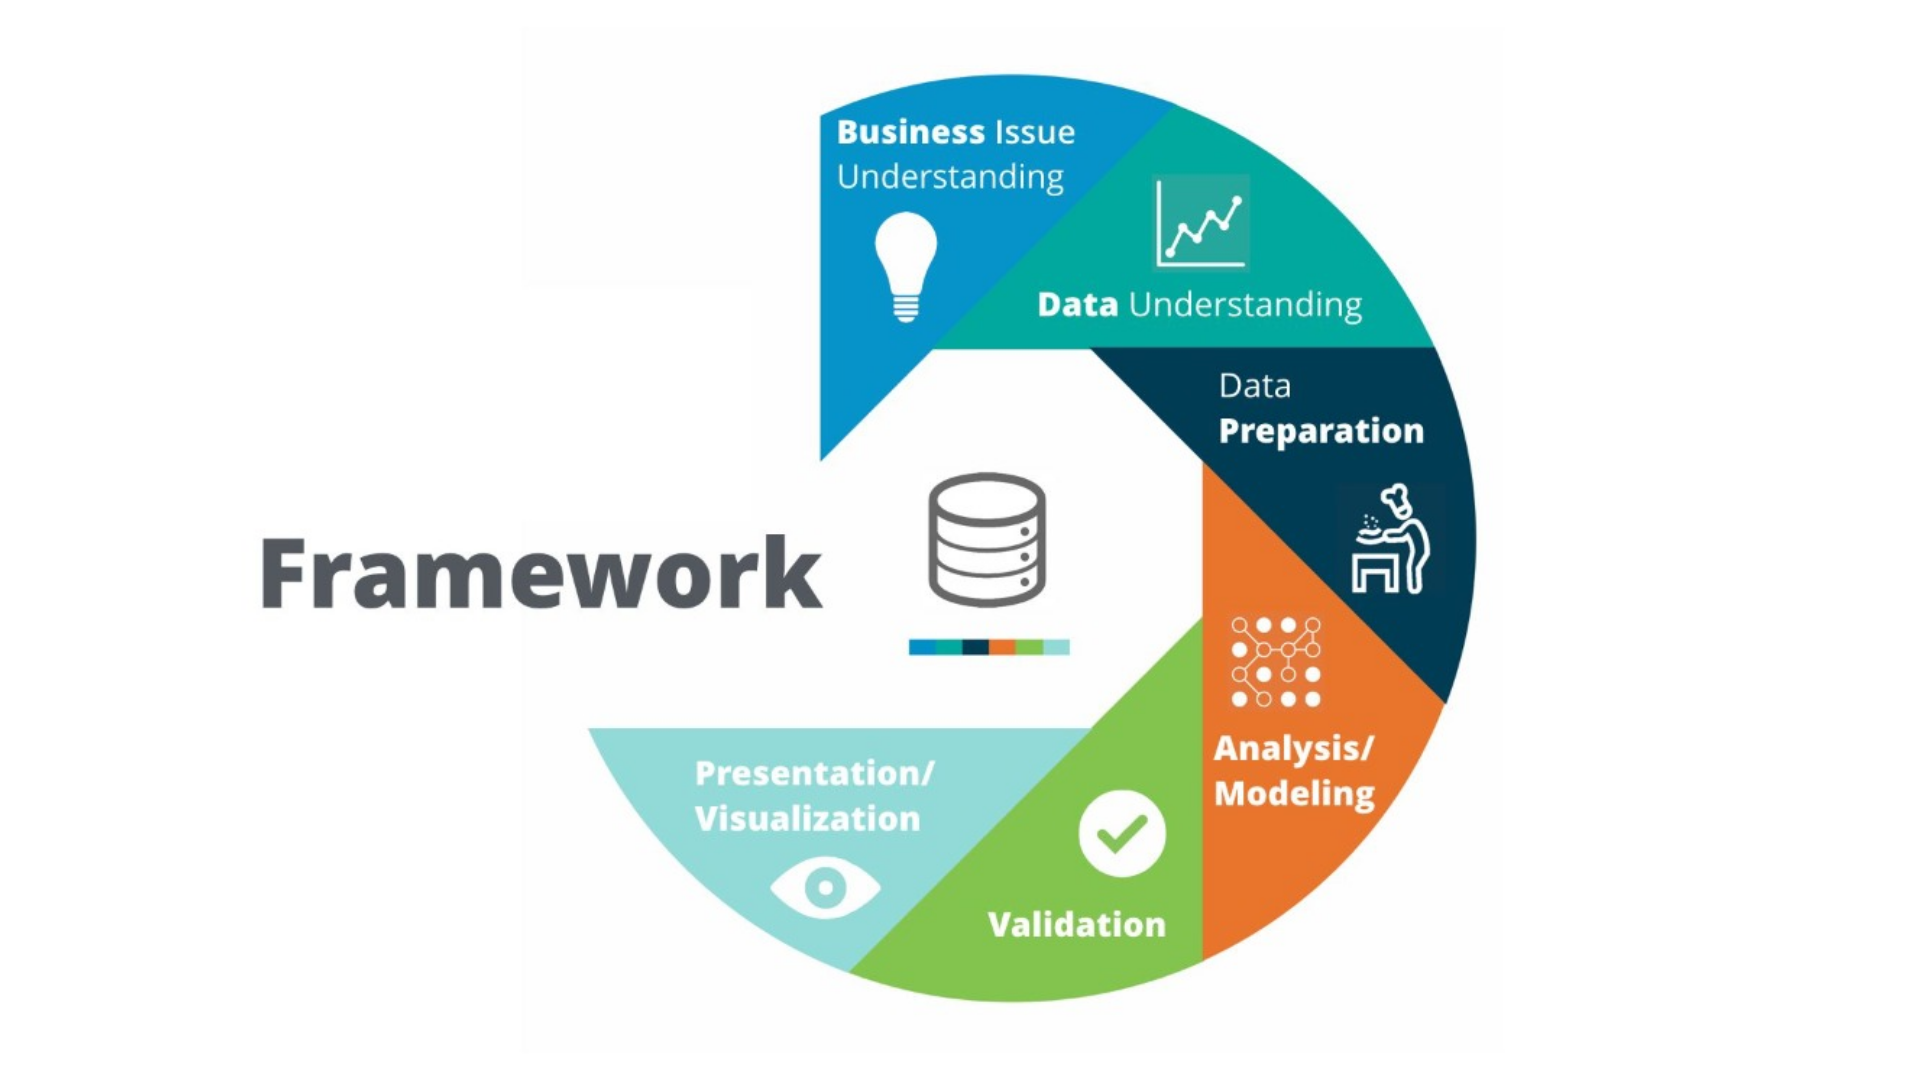

In [82]:
# Tabela de resultados das métricas
# data_30D3M_balanceado
summary = pd.DataFrame({
    'labels': ['Acurácia', 'Precisão', 'Recall', 'ROC'],
    'logreg': [logreg['test_accuracy'].mean(), logreg['test_precision'].mean(), logreg['test_recall'].mean(), logreg['test_roc_auc'].mean()],
    'trees': [trees['test_accuracy'].mean(), trees['test_precision'].mean(), trees['test_recall'].mean(), trees['test_roc_auc'].mean()],
    'forest': [forest['test_accuracy'].mean(), forest['test_precision'].mean(), forest['test_recall'].mean(), forest['test_roc_auc'].mean()],
    'xgb': [xgb['test_accuracy'].mean(), xgb['test_precision'].mean(), xgb['test_recall'].mean(), xgb['test_roc_auc'].mean()],                   
                       }).set_index('labels')
                      

summary.index.name=None
summary = summary.transpose()    
summary.style.applymap(lambda x: 'background-color: red' if x >= 0.8 else '')


In [83]:
# Tabela de resultados das métricas
# data_30D3M_balanceado
summary = pd.DataFrame({
    'labels': ['Acurácia', 'Precisão', 'Recall', 'ROC'],
    'logreg2': [logreg2['test_accuracy'].mean(), logreg2['test_precision'].mean(), logreg2['test_recall'].mean(), logreg2['test_roc_auc'].mean()],
    'trees2': [trees2['test_accuracy'].mean(), trees2['test_precision'].mean(), trees2['test_recall'].mean(), trees2['test_roc_auc'].mean()],
    'forest2': [forest2['test_accuracy'].mean(), forest2['test_precision'].mean(), forest2['test_recall'].mean(), forest2['test_roc_auc'].mean()],
    'xgb2': [xgb2['test_accuracy'].mean(), xgb2['test_precision'].mean(), xgb2['test_recall'].mean(), xgb2['test_roc_auc'].mean()],                   
                       }).set_index('labels')
                      

summary.index.name=None
summary = summary.transpose()    
summary.style.applymap(lambda x: 'background-color: red' if x >= 0.8 else '')

## Ajuste fino dos Hiperparâmetros 
Grid Search para escolher o melhor valor para os seguintes hiperparâmetros:
* criterion - decide qual variável escolher para os nós
* n_estimators - nº de árvores antes da votação
* max_depth - Profundidade da árvore
* min_samples_split- nº minimo de amostras para dividir o nó
* min_samples_leaf - nº minimo de amostras nas folhas


### PERFORMANCE DADOS DE TREINO ALEATÓRIA

In [84]:
# Random Forest

# Criterion

kfold = StratifiedKFold(n_splits=5, shuffle=True)

forest = RandomForestClassifier()

param_grid = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res, y_res)
criterion = result.best_params_['criterion'] 
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')


Melhor ajuste: 0.8995491773533173 para {'criterion': 'entropy'}


In [105]:
# n_estimators
forest = RandomForestClassifier(criterion=criterion)

param_grid = {'n_estimators': range(50, 500, 50)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res, y_res)
n_estimators = result.best_params_['n_estimators']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

Melhor ajuste: 0.9014273295053645 para {'n_estimators': 350}


In [106]:
# max_depth
forest = RandomForestClassifier(criterion=criterion, n_estimators= n_estimators)

param_grid = {'max_depth': range(1, 10)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res, y_res)
max_depth = result.best_params_['max_depth']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

Melhor ajuste: 0.7853187770307646 para {'max_depth': 9}


In [107]:
# min_samples_split
forest = RandomForestClassifier(criterion=criterion, n_estimators= n_estimators, max_depth= max_depth)

param_grid = {'min_samples_split': range(2, 10, 2)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res, y_res)
min_samples_split = result.best_params_['min_samples_split']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

Melhor ajuste: 0.7841723366856884 para {'min_samples_split': 4}


In [108]:
# min_samples_leaf
forest = RandomForestClassifier(criterion=criterion, n_estimators= n_estimators, max_depth= max_depth,
                                min_samples_split= min_samples_split)

param_grid = {'min_samples_leaf': range(1, 6, 2)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res, y_res)
min_samples_leaf = result.best_params_['min_samples_leaf']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

Melhor ajuste: 0.7889565863501422 para {'min_samples_leaf': 3}


              precision    recall  f1-score   support

           0       0.86      0.90      0.88     16861
           1       0.82      0.75      0.78      9794

    accuracy                           0.85     26655
   macro avg       0.84      0.83      0.83     26655
weighted avg       0.85      0.85      0.84     26655

ROC_AUC Score: 0.8265915575098861 



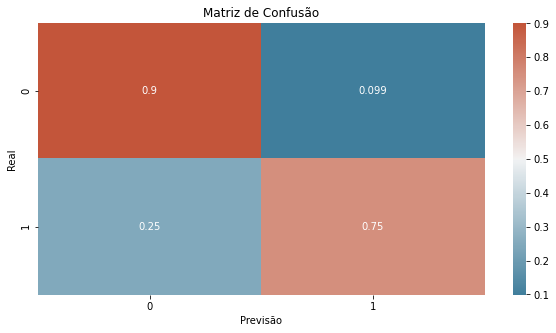

In [112]:
modelo = RandomForestClassifier(criterion=criterion, n_estimators= n_estimators,
                                max_depth= max_depth ,min_samples_split= min_samples_split,
                                min_samples_leaf=min_samples_leaf)
modelo.fit(X_res, y_res)

# Validação com os dados de teste
y_pred = modelo.predict(X_test)

print(classification_report(y_test, y_pred))
print(f'ROC_AUC Score: {roc_auc_score(y_test, y_pred)}', '\n')

fig, ax = plt.subplots(figsize=(10,5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True,cmap=cmap, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

### PERFORMANCE DADOS DE TREINO TEMPORAL

In [ ]:
# Random Forest

# Criterion

kfold = StratifiedKFold(n_splits=5, shuffle=True)

forest2 = RandomForestClassifier()

param_grid = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res2, y_res2)
criterion2 = result.best_params_['criterion'] 
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

In [ ]:
# n_estimators
forest2 = RandomForestClassifier(criterion=criterion2)

param_grid = {'n_estimators': range(50, 500, 50)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res2, y_res2)
n_estimators2 = result.best_params_['n_estimators']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

In [ ]:
# maX2_depth
forest2 = RandomForestClassifier(criterion=criterion2, n_estimators= n_estimators2)

param_grid = {'max_depth': range(1, 10)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res2, y_res2)
max_depth2 = result.best_params_['max_depth']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

In [ ]:
# min_samples_split
forest2 = RandomForestClassifier(criterion=criterion2, n_estimators= n_estimators2, max_depth= max_depth2)

param_grid = {'min_samples_split': range(2, 10, 2)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res2, y_res2)
min_samples_split2 = result.best_params_['min_samples_split']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

In [ ]:
# min_samples_leaf
forest2 = RandomForestClassifier(criterion=criterion2, n_estimators= n_estimators2, max_depth= max_depth2
                                , min_samples_split= min_samples_split2)

param_grid = {'min_samples_leaf': range(1, 6, 2)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_res2, y_res2)
min_samples_leaf2 = result.best_params_['min_samples_leaf']
print(f'Melhor ajuste: {result.best_score_} para {result.best_params_}')

##  AVALIAÇÃO COM DADOS DE TESTE DO MODELO COM AJUSTE FINO

In [ ]:
#Modelo ajustado Temporal
modelo2 = RandomForestClassifier(criterion=criterion2, n_estimators= n_estimators2,
                                max_depth= max_depth2 ,min_samples_split= min_samples_split2,
                                min_samples_leaf=min_samples_leaf2)
                                
modelo.fit(X_res2, y_res2)

# Validação com os dados de teste
y2_pred = modelo.predict(X2_test)

print(classification_report(y2_test, y2_pred))
print(f'ROC_AUC Score: {roc_auc_score(y2_test, y2_pred)}', '\n')

fig, ax = plt.subplots(figsize=(10,5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(confusion_matrix(y2_test, y2_pred, normalize='true'), annot=True,cmap=cmap, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

# 7 - **MODELOS ESCOLHIDOS**

In [ ]:
Melhor modelo foi o 

Nem sempre um conjunto de dados aleatórios é o melhor. No caso de dados temporais, Nesse caso o ideal é utilizar para o conjunto de  teste dados mais recentes, porque se o modelo tiver um bom desempenho em dados mais recentes, em um bom indicio que a emprendizagem passada está avaliando bem o futuro.